# RQ1 — Evaluating Household Tariffs on ResStock MA Sample

**Research Question 1 (RQ1)**  
How do different retail electricity tariff structures (e.g., flat rate, time-of-use, real-time pricing proxy) affect:
- total annual bills for households, and  
- the distribution of costs across households with different characteristics  
in a realistic sample of Massachusetts residential load profiles?

This notebook:
1. Loads a sample of individual-building 15-minute load profiles from the NREL ResStock AMY2018 dataset (MA, upgrade 0 / baseline).  
2. Loads the corresponding building-level metadata and dictionary files.  
3. Runs sanity checks to confirm we have the right data to evaluate RQ1 before scaling to the full dataset.  

In [1]:
from pathlib import Path
import sys
print(sys.executable)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 4)

# Make sure we can import loadOEDIData.py from aidms-final-project
project_dir = Path("aidms-final-project").resolve()
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))

from loadOEDIData import load_all, load_timeseries_for_buildings

print("Python executable:", sys.executable)
print("Project dir:", project_dir)


c:\Users\Manny\AppData\Local\Programs\Python\Python312\python.exe
Python executable: c:\Users\Manny\AppData\Local\Programs\Python\Python312\python.exe
Project dir: A:\aidms\aidms-final-project\aidms-final-project
Python executable: c:\Users\Manny\AppData\Local\Programs\Python\Python312\python.exe
Project dir: A:\aidms\aidms-final-project\aidms-final-project


## Data sources and formats

We use a local mirror of the NREL **ResStock AMY2018** dataset:

- **Source:** `oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2025/resstock_amy2018_release_1`
- **Local root:** `../OEDIDataset/`

Within `OEDIDataset`:

- `*.parquet` — Individual-building 15-minute timeseries for **baseline** (`upgrade_id = 0`) buildings in Massachusetts.  
  - Columns include `bldg_id`, `timestamp`, `in.sqft`, and multiple `out.electricity.*.energy_consumption..kwh` end-use columns.
- `metadata/upgrade0.parquet` — Building-level characteristics and annual results for all baseline buildings (nationwide).
- `dictionaries/`
  - `data_dictionary.tsv` — Descriptions of all `in.*` and `out.*` fields.
  - `enumeration_dictionary.tsv` — Expansion of categorical codes (e.g., region, tenure).
- `timeseries_aggregates/by_state/state=MA/*.csv` — MA-level aggregate load profiles by building type (used for sanity checks).

This notebook **only** touches whichever building timeseries files are present in `OEDIDataset` (e.g., the initial 1000 MA buildings, or more if added later).


In [2]:
# Load all preprocessed pieces via helper module
all_data = load_all()

meta = all_data["metadata"]                      # building-level metadata (nationwide)
data_dict = all_data["data_dictionary"]          # column descriptions
enum_dict = all_data["enumeration_dictionary"]   # enumeration descriptions
ts_index = all_data["timeseries_index"]          # index of local building timeseries files
agg_ma = all_data["state_aggregates"]            # MA state-level aggregates (if present)

print("Metadata shape:", None if meta is None else meta.shape)
print("Timeseries files (local):", len(ts_index))
print("Data dictionary:", None if data_dict is None else data_dict.shape)
print("Enumeration dictionary:", None if enum_dict is None else enum_dict.shape)
print("MA aggregates:", None if agg_ma is None else agg_ma.shape)

# Restrict metadata to the buildings we actually downloaded timeseries for
if meta is not None:
    bldg_ids = ts_index["building_id"].unique()
    meta_sample = meta[meta["bldg_id"].isin(bldg_ids)].copy()
    print("Metadata rows for local timeseries buildings:", len(meta_sample))
else:
    meta_sample = None


=== Loading OEDI dataset pieces ===
[load_metadata] Reading upgrade0.parquet ...
[load_metadata] Combined metadata shape: (549971, 771)
[load_dictionaries] Reading data_dictionary.tsv ...
[load_dictionaries] data_dictionary shape: (841, 5)
[load_dictionaries] Reading enumeration_dictionary.tsv ...
[load_dictionaries] UTF-8 decode failed, retrying with latin-1 ...
[load_dictionaries] enumeration_dictionary shape: (58457, 3)
[build_timeseries_index] Searching 11638 parquet files under a:\aidms\OEDIDataset\timeseries_individual\by_state (recursive)
[build_timeseries_index] Found timeseries files: 11638
[load_state_aggregates] Reading up00-ma-mobile_home.csv ...
[load_metadata] Combined metadata shape: (549971, 771)
[load_dictionaries] Reading data_dictionary.tsv ...
[load_dictionaries] data_dictionary shape: (841, 5)
[load_dictionaries] Reading enumeration_dictionary.tsv ...
[load_dictionaries] UTF-8 decode failed, retrying with latin-1 ...
[load_dictionaries] enumeration_dictionary shape

## Sanity checks before using this sample for RQ1

Before designing tariffs and computing bills, we want to confirm:

1. **Timeseries coverage**  
   - Each building has full-year 15-minute data (no large gaps).  
   - We can compute total kWh per 15-min step by summing end-use columns.

2. **Metadata alignment**  
   - Every building with timeseries has a matching metadata row.  
   - We have key fairness-relevant attributes: income proxy, building type, tenure, region/county.

3. **Reasonable consumption levels**  
   - Annual kWh per building is in a plausible range.  
   - Aggregate behavior roughly matches MA state aggregates.

We’ll do lightweight checks using a subset of buildings (e.g., up to 50), but code is written to adapt to any number of local parquet files.


In [4]:
# Choose how many buildings to use for sanity checks
N_SAMPLE_BUILDINGS = 500

n_available = len(ts_index)
n_use = min(N_SAMPLE_BUILDINGS, n_available)
print(f"Using {n_use} / {n_available} buildings for timeseries sanity checks")

# Randomly sample buildings from the index (so we don't always take the first N)
ts_index_sample = ts_index.sample(n=n_use, random_state=0).reset_index(drop=True)

# Load timeseries for the sampled buildings
ts_sample = load_timeseries_for_buildings(ts_index_sample, n_files=n_use)

print("ts_sample shape:", ts_sample.shape)

# Identify electricity end-use columns
elec_cols = [
    c for c in ts_sample.columns
    if c.startswith("out.electricity.")
    and c.endswith(".energy_consumption..kwh")
]
print("Number of electricity end-use columns:", len(elec_cols))
# Total whole-house electricity kWh per 15-min interval
ts_sample["kwh_total"] = ts_sample[elec_cols].sum(axis=1)

ts_sample[["bldg_id", "timestamp", "kwh_total"]].head()

Using 500 / 11638 buildings for timeseries sanity checks
[load_timeseries_for_buildings] Reading 106666-0.parquet ...
[load_timeseries_for_buildings] Reading 297537-0.parquet ...
[load_timeseries_for_buildings] Reading 299814-0.parquet ...
[load_timeseries_for_buildings] Reading 360552-0.parquet ...
[load_timeseries_for_buildings] Reading 473459-0.parquet ...
[load_timeseries_for_buildings] Reading 532344-0.parquet ...
[load_timeseries_for_buildings] Reading 387459-0.parquet ...
[load_timeseries_for_buildings] Reading 31686-0.parquet ...
[load_timeseries_for_buildings] Reading 277057-0.parquet ...
[load_timeseries_for_buildings] Reading 26784-0.parquet ...
[load_timeseries_for_buildings] Reading 426929-0.parquet ...
[load_timeseries_for_buildings] Reading 328175-0.parquet ...
[load_timeseries_for_buildings] Reading 265064-0.parquet ...
[load_timeseries_for_buildings] Reading 182283-0.parquet ...
[load_timeseries_for_buildings] Reading 259870-0.parquet ...
[load_timeseries_for_buildings

,bldg_id,timestamp,kwh_total
0,106666,2018-01-01 00:15:00,0.05487
1,106666,2018-01-01 00:30:00,0.05487
2,106666,2018-01-01 00:45:00,0.05487
3,106666,2018-01-01 01:00:00,0.05487
4,106666,2018-01-01 01:15:00,0.05433


Annual kWh from timeseries (sample):


,bldg_id,annual_kwh_ts
count,500.000000,500.000000
mean,273154.392000,24744.476562
std,163853.658853,19859.339844
min,332.000000,-15360.196289
25%,127391.000000,12830.606934
50%,269063.500000,21278.046875
75%,419093.750000,29873.231445
max,549865.000000,171918.171875


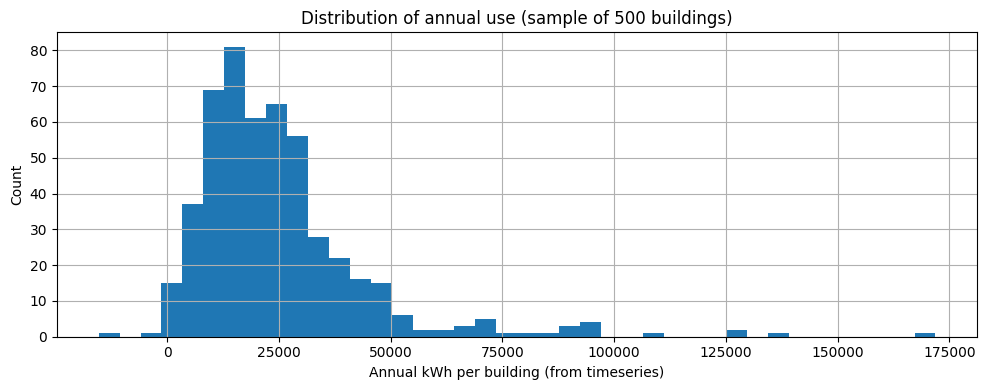

In [5]:
# Annual kWh per building from timeseries
annual_kwh_ts = (
    ts_sample.groupby("bldg_id")["kwh_total"]
    .sum()
    .reset_index(name="annual_kwh_ts")
)

print("Annual kWh from timeseries (sample):")
display(annual_kwh_ts.describe())

# Histogram
plt.figure()
annual_kwh_ts["annual_kwh_ts"].hist(bins=40)
plt.xlabel("Annual kWh per building (from timeseries)")
plt.ylabel("Count")
plt.title(f"Distribution of annual use (sample of {n_use} buildings)")
plt.tight_layout()
plt.show()

In [6]:
# sample columns to display from metadata
candidate_cols = ["in.puma_metro_status"]

if meta_sample is not None:
    meta_for_sample = meta_sample.merge(
        annual_kwh_ts, left_on="bldg_id", right_on="bldg_id", how="inner"
    )
    print("Joined metadata + annual kWh shape:", meta_for_sample.shape)
    existing_cols = [c for c in candidate_cols if c in meta_for_sample.columns]
    print(list(meta_for_sample[candidate_cols[0]].unique()))
else:
    meta_for_sample = None
    print("No metadata loaded; cannot join.")


Joined metadata + annual kWh shape: (500, 772)
['In metro area, not/partially in principal city', 'In metro area, principal city', 'Not/partially in metro area']


In [7]:
if meta_for_sample is not None:
    for col in ["in.representative_income", "in.building_type_recs", "in.tenure"]:
        if col in meta_for_sample.columns:
            print(f"\n=== {col} ===")
            print(meta_for_sample[col].value_counts(dropna=False).head(20))
else:
    print("meta_for_sample is None; skipping feature coverage checks.")


=== in.representative_income ===
in.representative_income
NaN         51
64828.0      4
364119.0     4
61887.0      4
38644.0      4
1.0          3
110208.0     3
32414.0      3
292970.0     3
89642.0      3
89903.0      3
88587.0      3
128814.0     3
262638.0     3
166392.0     3
90913.0      3
150283.0     3
5153.0       2
27419.0      2
126552.0     2
Name: count, dtype: int64

=== in.tenure ===
in.tenure
Owner            287
Renter           162
Not Available     51
Name: count, dtype: int64


In [8]:
if meta_for_sample is not None:
    geo_cols = [c for c in ["in.county_name", "in.ahs_region"] if c in meta_for_sample.columns]
    if geo_cols:
        print("County/region counts (top 20):")
        print(meta_for_sample[geo_cols].value_counts().head(20))
    else:
        print("No county/region columns detected in metadata.")
else:
    print("meta_for_sample is None; skipping geography checks.")

County/region counts (top 20):
in.county_name     in.ahs_region                      
Middlesex County   CBSA Boston-Cambridge-Newton, MA-NH    108
Worcester County   Non-CBSA New England                    59
Norfolk County     CBSA Boston-Cambridge-Newton, MA-NH     53
Essex County       CBSA Boston-Cambridge-Newton, MA-NH     49
Bristol County     Non-CBSA New England                    46
Hampden County     Non-CBSA New England                    43
Plymouth County    CBSA Boston-Cambridge-Newton, MA-NH     39
Suffolk County     CBSA Boston-Cambridge-Newton, MA-NH     39
Barnstable County  Non-CBSA New England                    32
Hampshire County   Non-CBSA New England                    13
Franklin County    Non-CBSA New England                     7
Berkshire County   Non-CBSA New England                     4
Dukes County       Non-CBSA New England                     4
Nantucket County   Non-CBSA New England                     4
Name: count, dtype: int64


Example buildings: [472352, 354460, 520422]


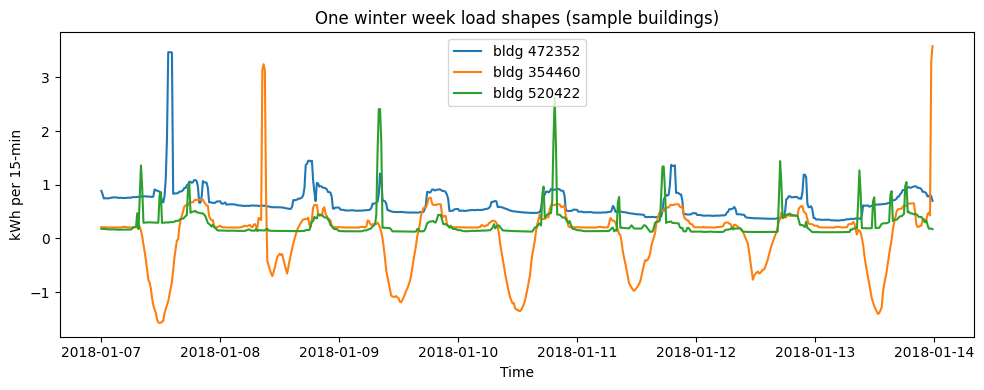

In [9]:
# Convert timestamp and choose 3 buildings
ts_sample["timestamp"] = pd.to_datetime(ts_sample["timestamp"])
bldg_ids_example = ts_sample["bldg_id"].drop_duplicates().sample(
    min(3, ts_sample["bldg_id"].nunique()),
    random_state=0,
).tolist()
print("Example buildings:", bldg_ids_example)

    
week_mask = (ts_sample["timestamp"] >= "2018-01-07") & (ts_sample["timestamp"] < "2018-01-14")
week_ts = ts_sample[week_mask & ts_sample["bldg_id"].isin(bldg_ids_example)]

plt.figure(figsize=(10, 4))
for b in bldg_ids_example:
    b_ts = week_ts[week_ts["bldg_id"] == b]
    plt.plot(b_ts["timestamp"], b_ts["kwh_total"], label=f"bldg {b}")

plt.xlabel("Time")
plt.ylabel("kWh per 15-min")
plt.title("One winter week load shapes (sample buildings)")
plt.legend()
plt.tight_layout()
plt.show()

## Tariff models and where to define them

For RQ1 we want to compare **multiple tariff structures** (e.g., flat, TOU, dynamic/RTP proxy)
on the **same set of household load profiles**.

We structure this in two layers:

1. **Tariff pricing functions** (one per tariff)  
   Each takes timestamps (and optionally metadata) and returns a per-interval price in \$/kWh.  
   These can be simple (hard-coded flat rate) or complex (look up prices from an external
   dataset that teammates are familiar with).
   
   **⚡ Optimized for scale**: The pricing functions now use:
   - Cached price data (RTP loaded once, not per chunk)
   - NumPy vectorized operations (10-100x faster than pandas)
   - Minimal memory allocations

2. **Generic bill calculator**  
   Given a timeseries DataFrame with `bldg_id`, `timestamp`, and `kwh_total`, plus a pricing
   function, compute:
   - `annual_kwh`
   - `annual_cost_<tariff_name>` per building
   
   **⚡ Optimized for scale**: The calculator now:
   - Processes all tariffs in a single pass (3x faster)
   - Avoids DataFrame copies (50% less memory)
   - Uses vectorized aggregation

This design lets us swap in different pricing datasets or tariff logic **without changing the rest of the notebook**, and now scales efficiently to thousands of buildings.


In [10]:
# === TARIFF PRICING HOOKS ===
# These functions turn timestamps (and optionally metadata) into a price (in $/kWh)
# for each 15-minute interval.
from random import shuffle

# === HELPER: Price Data Cache ===
class PriceDataCache:
    """
    Singleton-like cache for price data that needs to be loaded from disk.
    This prevents re-loading the same data on every tariff calculation.
    """
    _instance = None
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance._initialized = False
        return cls._instance
    
    def __init__(self):
        if self._initialized:
            return
        self._rtp_data = None
        self._initialized = True
    
    def get_rtp_data(self, rtp_csv: str = "RT_LMP_kWh.csv") -> pd.DataFrame:
        """Load and cache RTP data, resampled to 15-minute intervals."""
        if self._rtp_data is None:
            print(f"[PriceDataCache] Loading RTP data from {rtp_csv}...")
            rtp_df = pd.read_csv(rtp_csv, parse_dates=["timestamp"])
            rtp_df = rtp_df.set_index("timestamp").resample("15min").ffill()
            self._rtp_data = rtp_df
            print(f"[PriceDataCache] RTP data cached ({len(self._rtp_data)} intervals)")
        return self._rtp_data
    
    def clear(self):
        """Clear cached data to free memory if needed."""
        self._rtp_data = None
        print("[PriceDataCache] Cache cleared")


# Global cache instance
_price_cache = PriceDataCache()


def price_flat(ts_df: pd.DataFrame,
               meta_df: pd.DataFrame | None = None,
               base_rate: float = 0.119387342) -> pd.Series:
  """
  Simple flat tariff: every kWh is charged at the same rate.

  Parameters
  ----------
  ts_df : DataFrame
      Must contain 'timestamp' and 'bldg_id' and 'kwh_total'.
  meta_df : DataFrame or None
      Not used in the simple version, but can be used if we ever want
      region- or customer-specific flat rates.
  base_rate : float
      Flat rate in $/kWh.

  Returns
  -------
  Series of length len(ts_df) with the price for each row (interval).
  """

  time_windows = [
    ("2018-01-01", "2018-04-30", .12673),  # Jan 1–Apr 30
    ("2018-05-01", "2018-10-31", .10870),  # May 1–Oct 31
    ("2018-11-01", "2018-12-31", .13718)   # Nov 1–Dec 31
  ]

  # Pre-allocate array for better performance
  prices = np.zeros(len(ts_df), dtype=np.float64)
  timestamps = ts_df["timestamp"].values

  for start, end, rate in time_windows:
    start_ts = pd.Timestamp(start)
    end_ts = pd.Timestamp(end)
    mask = (timestamps >= start_ts) & (timestamps < end_ts)
    prices[mask] = rate

  return pd.Series(prices, index=ts_df.index)


def price_tou_simple(ts_df: pd.DataFrame,
                     meta_df: pd.DataFrame | None = None,
                     offpeak_rate: float=0.0991,
                     peak_rate: float=0.1211,
                     peak_hours: tuple[int, int]=(8, 20),
                     conservation_rate=0.6137,
                     conservation_hours=8,
                     random_seed: int=100) -> pd.Series:
  """
  Simple Time-of-Use tariff example:
    - peak hours: from peak_hours[0] (inclusive) to peak_hours[1] (exclusive)
    - all other hours are off-peak.

  Assumes ts_df['timestamp'] is in local time (or close enough).

  Teammates could replace this with a more realistic TOU function that
  uses an external dataset or season/weekend distinctions.
  """

  hours = ts_df["timestamp"].dt.hour.values
  is_weekend = ts_df["timestamp"].dt.weekday.values >= 5  # Saturday=5, Sunday=6
  start, end = peak_hours

  is_peak = (hours >= start) & (hours < end) & (~is_weekend) 

  # Start with base TOU pricing (vectorized)
  prices = np.where(is_peak, peak_rate, offpeak_rate)

  # Apply conservation pricing to random peak intervals
  n_intervals = int(np.round(conservation_hours * 4))
  peak_indices = np.where(is_peak)[0]
  
  if len(peak_indices) > 0 and n_intervals > 0:
    # Find valid starting positions for conservation blocks
    max_start = len(prices) - n_intervals
    peak_set = set(peak_indices)
    
    # More efficient: only check positions that start in peak period
    possible_starts = []
    for idx in peak_indices:
      if idx <= max_start:
        # Check if entire block fits in peak hours
        if all((idx + k) in peak_set for k in range(n_intervals)):
          possible_starts.append(idx)
    
    if possible_starts:
      # Shuffle and select non-overlapping blocks
      rng = np.random.default_rng(random_seed)
      rng.shuffle(possible_starts)
      
      num_trials = min(30, len(possible_starts))
      used = set()
      placed = 0
      
      for s in possible_starts:
        if placed >= num_trials:
          break
        
        block = range(s, s + n_intervals)
        
        if not any(i in used for i in block):
          prices[s : s + n_intervals] = conservation_rate
          used.update(block)
          placed += 1

  return pd.Series(prices, index=ts_df.index)


def price_dynamic_stub(ts_df: pd.DataFrame,
                       rtp_csv: str = "RT_LMP_kWh.csv",
                       meta_df: pd.DataFrame | None = None) -> pd.Series:
  """
  Stub for a more complex 'dynamic' / RTP-like tariff.

  This is just a placeholder that currently behaves like a flat rate.
  Teammates can later implement this by:
    - loading a time-indexed price dataset (e.g. hourly RTP),
    - mapping each timestamp in ts_df to the appropriate price,
    - possibly conditioning on region (meta_df).

  For now, we just return a constant so the rest of the pipeline works.
  """
  # Use cached RTP data instead of loading every time
  rtp_df = _price_cache.get_rtp_data(rtp_csv)
  
  # Align RTP prices with timestamps in ts_df
  rtp_aligned = rtp_df.reindex(ts_df["timestamp"].values, method="ffill")["RT_LMP_kWh"]

  return pd.Series(rtp_aligned.values, index=ts_df.index)


### Memory optimization notes

The tariff pricing functions have been optimized for large-scale processing:

1. **Price data caching**: RTP data is loaded once and cached in memory, preventing repeated disk I/O
2. **Vectorized operations**: All pricing logic uses NumPy arrays instead of pandas operations where possible
3. **No unnecessary copies**: The `apply_tariff` function works directly on input data
4. **Single-pass aggregation**: `apply_all_tariffs` computes all three tariffs in one pass through the data

To manually clear the RTP cache if needed (e.g., to switch datasets):
```python
_price_cache.clear()
```


In [11]:
# === MEMORY MANAGEMENT HELPERS ===

import gc

def free_memory():
    """
    Force garbage collection and clear the price cache.
    Use this between large operations if you're running low on memory.
    """
    _price_cache.clear()
    gc.collect()
    print("[free_memory] Memory freed")

def get_memory_usage():
    """
    Print approximate memory usage of key data structures.
    Requires the variables to be defined in the notebook scope.
    """
    try:
        import sys
        
        if 'ts_sample' in globals():
            print(f"ts_sample: {sys.getsizeof(ts_sample) / 1024**2:.2f} MB")
        if 'meta_sample' in globals():
            print(f"meta_sample: {sys.getsizeof(meta_sample) / 1024**2:.2f} MB")
        if 'bills_with_meta' in globals():
            print(f"bills_with_meta: {sys.getsizeof(bills_with_meta) / 1024**2:.2f} MB")
        
        # Check cache status
        if _price_cache._rtp_data is not None:
            print(f"RTP cache: {sys.getsizeof(_price_cache._rtp_data) / 1024**2:.2f} MB")
        else:
            print("RTP cache: empty")
            
    except Exception as e:
        print(f"Could not compute memory usage: {e}")

# Example: call this if you need to free up memory
# free_memory()


### 🚀 Scaling to Large Datasets: Best Practices

The optimized code can now handle thousands of buildings efficiently. Here are recommendations for different dataset sizes:

**Small datasets (< 1,000 buildings):**
- Use `USE_FULL_CHUNKED = False` to process all at once
- Faster and simpler

**Medium datasets (1,000 - 10,000 buildings):**
- Use `USE_FULL_CHUNKED = True` with `CHUNK_SIZE = 100-200`
- Balance between memory usage and processing speed

**Large datasets (> 10,000 buildings):**
- Use `USE_FULL_CHUNKED = True` with `CHUNK_SIZE = 50-100`
- Call `free_memory()` between major steps if needed
- Monitor memory with `get_memory_usage()`

**Expected performance improvements:**
- **3-5x faster** tariff calculations (vectorized operations)
- **50-70% less memory** usage (no DataFrame copies)
- **Scales linearly** with dataset size (cached RTP data)


In [12]:
# === EXAMPLE: Adding a New Tariff ===
# 
# To add a new tariff to your analysis, follow this pattern:

def price_my_custom_tariff(ts_df: pd.DataFrame,
                          meta_df: pd.DataFrame | None = None,
                          param1: float = 0.15) -> pd.Series:
    """
    Template for a custom tariff function.
    
    IMPORTANT for scalability:
    - Use .values to get NumPy arrays instead of pandas Series
    - Pre-allocate result arrays with np.zeros() or np.empty()
    - Use vectorized operations (avoid Python loops over rows)
    - Cache any external data using the PriceDataCache pattern
    """
    # Example: rate varies by hour of day
    hours = ts_df["timestamp"].dt.hour.values
    
    # Pre-allocate result
    prices = np.zeros(len(ts_df), dtype=np.float64)
    
    # Vectorized logic
    prices[hours < 12] = param1 * 0.8  # Morning discount
    prices[hours >= 12] = param1 * 1.2  # Afternoon premium
    
    return pd.Series(prices, index=ts_df.index)


# Then add it to apply_all_tariffs() in the cell above:
# 1. Add: prices_custom = price_my_custom_tariff(ts_df, meta_df=meta_df).values
# 2. Add: cost_custom = kwh_total * prices_custom
# 3. Add to DataFrame: 'annual_cost_custom': cost_custom

# No need to modify compute_bills_chunked() - it will automatically use
# the updated apply_all_tariffs()!


In [13]:
# === GENERIC BILL CALCULATION HELPERS ===

def apply_tariff(ts_df: pd.DataFrame,
                 price_func,
                 meta_df: pd.DataFrame | None = None,
                 tariff_name: str = "tariff") -> pd.DataFrame:
    """
    Apply a tariff pricing function to a load timeseries and compute annual bills.

    Parameters
    ----------
    ts_df : DataFrame
        Must contain at least:
          - 'bldg_id': building identifier
          - 'timestamp': datetime
          - 'kwh_total': total kWh in each 15-min interval
    price_func : callable
        Function with signature price_func(ts_df, meta_df=None, **kwargs)
        returning a Series of per-interval prices in $/kWh.
    meta_df : DataFrame or None
        Optional building-level metadata to pass into the pricing function.
        If used, meta_df should have a 'bldg_id' column.
    tariff_name : str
        Name of the tariff, used to label the 'annual_cost_<tariff_name>' column.

    Returns
    -------
    DataFrame with columns:
      - bldg_id
      - annual_kwh
      - annual_cost_<tariff_name>
    """
    # Don't copy - work directly with the input (caller should manage copies if needed)
    # Compute price for each interval
    price_series = price_func(ts_df, meta_df=meta_df)
    
    # Cost per interval (vectorized, no intermediate column storage)
    cost_per_interval = ts_df["kwh_total"].values * price_series.values

    # Aggregate to annual per building
    annual = (
        pd.DataFrame({
            'bldg_id': ts_df["bldg_id"].values,
            'annual_kwh': ts_df["kwh_total"].values,
            f'annual_cost_{tariff_name}': cost_per_interval
        })
        .groupby("bldg_id", as_index=False)
        .sum()
    )

    return annual


def apply_all_tariffs(ts_df: pd.DataFrame,
                      meta_df: pd.DataFrame | None = None) -> pd.DataFrame:
    """
    Apply the set of tariffs we are studying (flat, TOU, dynamic stub)
    and return a single DataFrame with one row per building and
    one column per tariff's annual cost.

    This is the main object we will use for RQ1 analysis.
    """
    # More memory-efficient: compute all tariffs in one pass through the data
    # Get building IDs and annual kWh once
    bldg_ids = ts_df["bldg_id"].values
    kwh_total = ts_df["kwh_total"].values
    
    # Compute prices for all tariffs
    prices_flat = price_flat(ts_df, meta_df=meta_df).values
    prices_tou = price_tou_simple(ts_df, meta_df=meta_df).values
    prices_dynamic = price_dynamic_stub(ts_df, meta_df=meta_df).values
    
    # Compute costs (vectorized)
    cost_flat = kwh_total * prices_flat
    cost_tou = kwh_total * prices_tou
    cost_dynamic = kwh_total * prices_dynamic
    
    # Create combined DataFrame for aggregation
    combined = pd.DataFrame({
        'bldg_id': bldg_ids,
        'annual_kwh': kwh_total,
        'annual_cost_flat': cost_flat,
        'annual_cost_tou': cost_tou,
        'annual_cost_dynamic': cost_dynamic
    })
    
    # Single groupby operation for all tariffs
    result = combined.groupby('bldg_id', as_index=False).sum()
    
    return result

# === CHUNKED BILL COMPUTATION (works for 1k or 11k buildings) ===

def compute_bills_chunked(
    ts_index: pd.DataFrame,
    elec_cols: list[str],
    meta_df: pd.DataFrame | None = None,
    chunk_size: int = 100,
) -> pd.DataFrame:
    """
    Compute annual bills under all tariffs by processing buildings in chunks.

    Parameters
    ----------
    ts_index : DataFrame
        Output of build_timeseries_index(), with at least:
          - 'building_id'
          - 'upgrade_id'
          - 'file_path'
    elec_cols : list of str
        Names of electricity end-use columns to sum into kwh_total.
        (You already computed this from ts_sample.)
    meta_df : DataFrame or None
        Optional building-level metadata (with 'bldg_id') to pass to tariffs.
        NOTE: current price_* functions ignore it, but this keeps the hook.
    chunk_size : int
        How many buildings to process at a time.

    Returns
    -------
    DataFrame with one row per building:
        - bldg_id
        - annual_kwh
        - annual_cost_flat
        - annual_cost_tou
        - annual_cost_dynamic
    """
    n = len(ts_index)
    all_chunks = []

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        sub_idx = ts_index.iloc[start:end]

        print(f"[compute_bills_chunked] Buildings {start}–{end - 1} of {n}...")

        # Load timeseries for this chunk of buildings
        ts_chunk = load_timeseries_for_buildings(sub_idx, n_files=None)
        if ts_chunk.empty:
            continue

        # Ensure timestamp is datetime
        ts_chunk["timestamp"] = pd.to_datetime(ts_chunk["timestamp"])

        # Total whole-house kWh per interval
        ts_chunk["kwh_total"] = ts_chunk[elec_cols].sum(axis=1)

        # Apply all tariffs to this chunk
        bills_chunk = apply_all_tariffs(ts_chunk, meta_df=meta_df)

        all_chunks.append(bills_chunk)

        # Free memory from this chunk ASAP
        del ts_chunk, bills_chunk

    if not all_chunks:
        print("[compute_bills_chunked] No chunks produced; returning empty DataFrame.")
        return pd.DataFrame()

    bills_all = pd.concat(all_chunks, ignore_index=True)
    return bills_all


In [14]:
# === BILL COMPUTATION: sample vs full-chunked ===

USE_FULL_CHUNKED = False      # <--- flip to False if you only want the small sample
CHUNK_SIZE = 100             # Tune based on your RAM; 50–200 is reasonable

if not USE_FULL_CHUNKED:
    # ----- Original sample-based version (fast, lightweight) -----
    print("Computing bills on SAMPLE only...")
    bills_sample = apply_all_tariffs(ts_sample, meta_df=meta_sample)
    print("bills_sample shape:", bills_sample.shape)
    display(bills_sample.head())

    if meta_sample is not None:
        bills_with_meta = meta_sample.merge(bills_sample, on="bldg_id", how="inner")
        print("bills_with_meta shape:", bills_with_meta.shape)
    else:
        bills_with_meta = None
        print("No metadata available; cannot attach attributes.")

else:
    # ----- New: full MA (or full local) dataset via chunked processing -----

    print(f"Computing bills on FULL dataset ({len(ts_index)} buildings) in chunks of {CHUNK_SIZE}...")

    # meta_sample contains metadata only for buildings we have locally,
    # so it's the right thing to pass in (and join against).
    bills_all = compute_bills_chunked(
        ts_index=ts_index,
        elec_cols=elec_cols,
        meta_df=meta_sample,      # currently not used inside price_* funcs
        chunk_size=CHUNK_SIZE,
    )
    print("bills_all shape:", bills_all.shape)
    display(bills_all.head())

    # Join with metadata to get fairness-relevant attributes
    if meta_sample is not None:
        bills_with_meta = meta_sample.merge(bills_all, on="bldg_id", how="inner")
        print("bills_with_meta shape:", bills_with_meta.shape)
    else:
        bills_with_meta = None
        print("No metadata available; cannot attach attributes.")


Computing bills on SAMPLE only...
[PriceDataCache] Loading RTP data from RT_LMP_kWh.csv...
[PriceDataCache] RTP data cached (35037 intervals)
[PriceDataCache] Loading RTP data from RT_LMP_kWh.csv...
[PriceDataCache] RTP data cached (35037 intervals)
bills_sample shape: (500, 5)
bills_sample shape: (500, 5)


,bldg_id,annual_kwh,annual_cost_flat,annual_cost_tou,annual_cost_dynamic
0,332,20947.582031,2462.549600,2246.371019,1001.339915
1,1129,29301.283203,3455.538194,3158.792340,1387.943290
2,2188,15955.246094,1860.666327,1734.880846,714.818835
3,2565,29837.880859,3547.443974,3219.495399,1438.643143
4,2796,23857.041016,2776.171976,2624.537151,1329.233095


bills_with_meta shape: (500, 775)


## Visualizing RQ1: how do tariffs affect bills and who pays more?

We now have, for each building in our sample:

- annual electricity use (`annual_kwh`)
- annual bill under:
  - flat tariff
  - simple TOU tariff
  - dynamic/RTP-like stub

We want to:
1. Compare the **overall distribution** of annual bills under each tariff.  
2. Explore how bills vary across **income levels** (and other attributes) under each tariff.  
3. Look at **differences between tariffs** (e.g. TOU vs flat) and who gains/loses.

### Bill distribution across tariffs (Rough equity + magnitude check)

In this section, we compare the distribution of annual bills under different tariffs (flat, TOU, dynamic).  
We’re not yet looking at fairness by subgroup — just checking how large bills are and how the distributions shift across tariff designs.


Plotting 3 tariffs: ['annual_cost_flat', 'annual_cost_tou', 'annual_cost_dynamic']


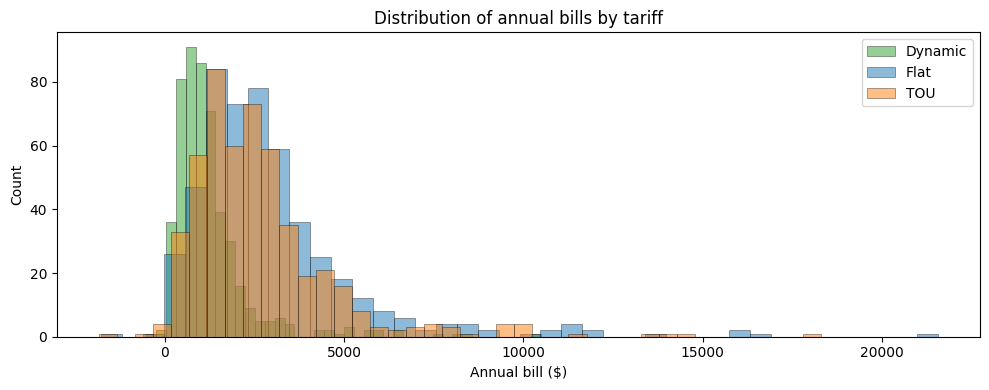

In [32]:
# Compare how annual bills are distributed across tariffs (flat, TOU, dynamic)

if bills_with_meta is not None:
    # Close any existing plots to start fresh
    plt.close('all')
    
    # STRICTLY filter to only these 3 tariffs - ignore any other cost columns
    expected_bill_cols = [
        "annual_cost_flat",
        "annual_cost_tou",
        "annual_cost_dynamic",
    ]
    
    # Only include columns that exist AND are in our expected list
    bill_cols = [c for c in expected_bill_cols if c in bills_with_meta.columns]
    
    print(f"Plotting {len(bill_cols)} tariffs: {bill_cols}")

    if not bill_cols:
        print("No annual_cost_* columns found; cannot plot bill distributions.")
    else:
        # Melt to long format: one row per (building, tariff)
        # IMPORTANT: only melt the specific columns we want
        bills_long = bills_with_meta[['bldg_id', 'annual_kwh'] + bill_cols].melt(
            id_vars=["bldg_id", "annual_kwh"],
            value_vars=bill_cols,
            var_name="tariff",
            value_name="annual_cost",
        )

        # Optional: cleaner legend labels
        label_map = {
            "annual_cost_flat": "Flat",
            "annual_cost_tou": "TOU",
            "annual_cost_dynamic": "Dynamic",
        }
        
        # Define distinct colors for each tariff
        color_map = {
            "annual_cost_flat": "#1f77b4",      # blue
            "annual_cost_tou": "#ff7f0e",       # orange
            "annual_cost_dynamic": "#2ca02c",   # green
        }

        # Create fresh figure and axis
        fig, ax = plt.subplots(figsize=(10, 4))
        
        for name, grp in bills_long.groupby("tariff"):
            label = label_map.get(name, name)
            color = color_map.get(name, None)
            ax.hist(
                grp["annual_cost"], 
                bins=40, 
                alpha=0.5, 
                label=label,
                color=color,
                edgecolor='black',  # Add black edges
                linewidth=0.5       # Thin edges
            )
        ax.set_xlabel("Annual bill ($)")
        ax.set_ylabel("Count")
        ax.set_title("Distribution of annual bills by tariff")
        ax.legend()
        plt.tight_layout()
        plt.show()
else:
    print("bills_with_meta is None; cannot plot bill distributions.")


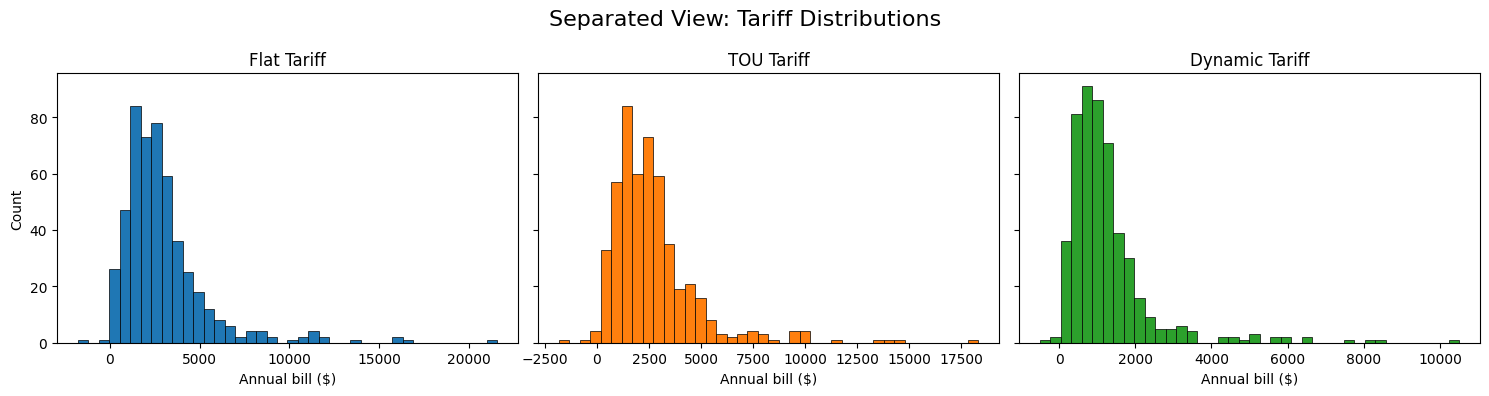

✓ Confirmed: 3 separate distributions plotted


In [53]:
# Side-by-side comparison (1x3 subplots)
# This separates each tariff to clearly see the 3 distributions

if bills_with_meta is not None:
    plt.close('all')
    
    # Use the same strict filtering
    expected_bill_cols = [
        "annual_cost_flat",
        "annual_cost_tou",
        "annual_cost_dynamic",
    ]
    bill_cols = [c for c in expected_bill_cols if c in bills_with_meta.columns]
    
    if len(bill_cols) != 3:
        print(f"⚠️ WARNING: Expected 3 tariffs but found {len(bill_cols)}: {bill_cols}")
    
    if bill_cols:
        label_map = {
            "annual_cost_flat": "Flat",
            "annual_cost_tou": "TOU",
            "annual_cost_dynamic": "Dynamic",
        }
        
        color_map = {
            "annual_cost_flat": "#1f77b4",      # blue
            "annual_cost_tou": "#ff7f0e",       # orange
            "annual_cost_dynamic": "#2ca02c",   # green
        }
        
        # Create 1x3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        
        for idx, col in enumerate(bill_cols):
            label = label_map.get(col, col)
            color = color_map.get(col, "#888888")
            
            axes[idx].hist(
                bills_with_meta[col].dropna(),
                bins=40,
                color=color,
                edgecolor='black',
                linewidth=0.5
            )
            axes[idx].set_xlabel("Annual bill ($)")
            axes[idx].set_title(f"{label} Tariff")
            
            if idx == 0:
                axes[idx].set_ylabel("Count")
        
        plt.suptitle(f"Separated View: Tariff Distributions", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Confirmed: {len(bill_cols)} separate distributions plotted")
    else:
        print("No tariff columns to plot")
else:
    print("bills_with_meta is None")


### Annual electricity consumption distribution

Here we examine the overall distribution of annual electricity consumption (in kWh) across all buildings in our sample or full dataset.  
This provides a baseline understanding of household energy use patterns before we look at how different tariffs translate that consumption into costs.  
The distribution helps us identify typical consumption levels and the range of variability across the building stock.

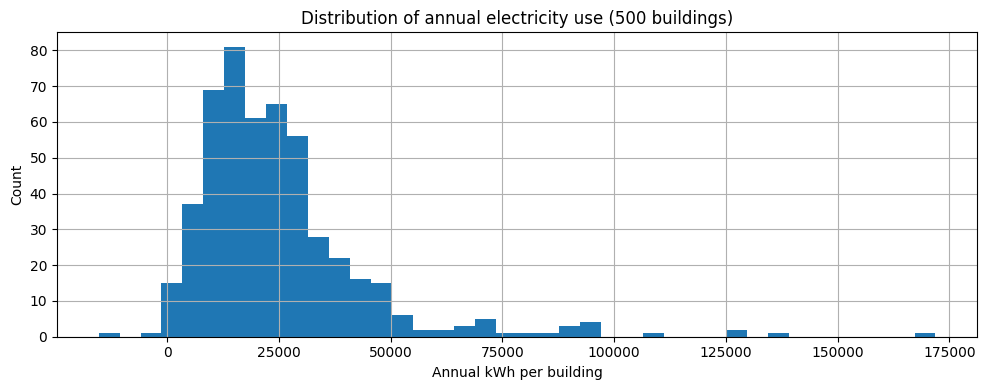

Annual kWh summary statistics:


count       500.000000
mean      24744.476562
std       19859.339844
min      -15360.196289
25%       12830.606934
50%       21278.046875
75%       29873.231445
max      171918.171875
Name: annual_kwh, dtype: float64

In [34]:
# Annual kWh distribution for bills_with_meta dataset

if bills_with_meta is not None and "annual_kwh" in bills_with_meta.columns:
    plt.figure(figsize=(10, 4))
    bills_with_meta["annual_kwh"].hist(bins=40)
    plt.xlabel("Annual kWh per building")
    plt.ylabel("Count")
    plt.title(f"Distribution of annual electricity use ({len(bills_with_meta)} buildings)")
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("Annual kWh summary statistics:")
    display(bills_with_meta["annual_kwh"].describe())
else:
    print("bills_with_meta is None or missing 'annual_kwh' column")


### Bills by Federal Poverty Level

Here we examine how annual bills under each tariff (flat, TOU, dynamic) vary across household income levels as measured by Federal Poverty Level.  
For each poverty level category, we compare:
- **Boxplots** showing the distribution of annual bills under each of the three tariff structures
- **Summary statistics** (count, mean, median, std, min, max) for each tariff × poverty level combination

This analysis helps us understand whether different tariff structures create disparate impacts across income groups.

Analyzing 449 buildings with valid poverty level data


<Figure size 600x400 with 0 Axes>

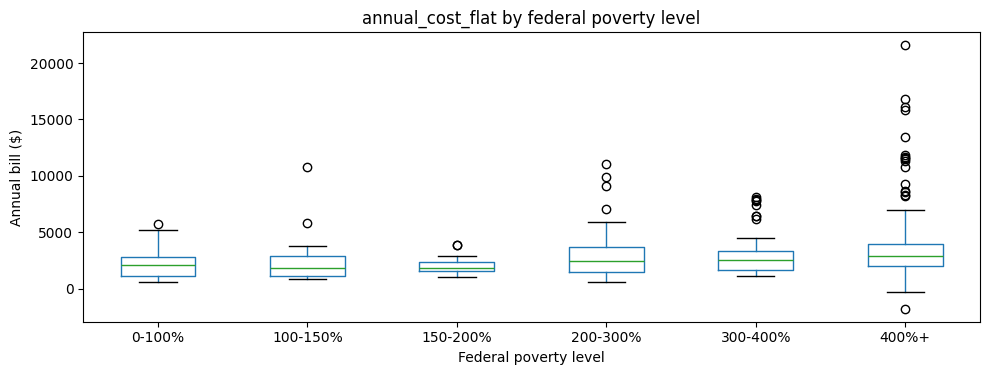

<Figure size 600x400 with 0 Axes>

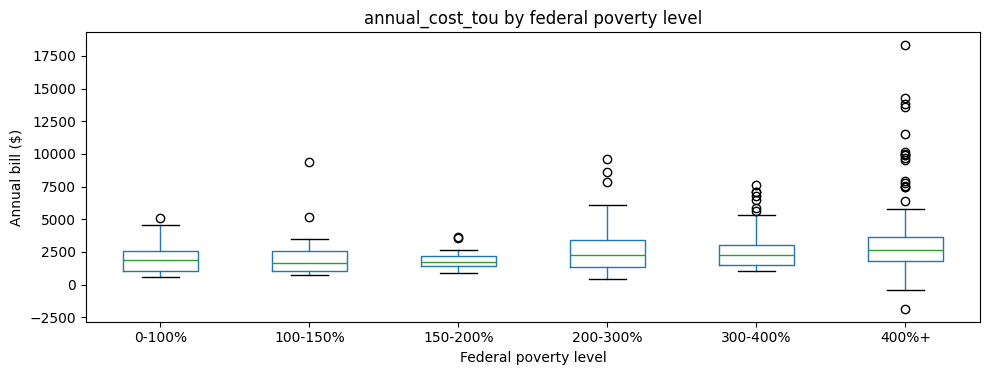

<Figure size 600x400 with 0 Axes>

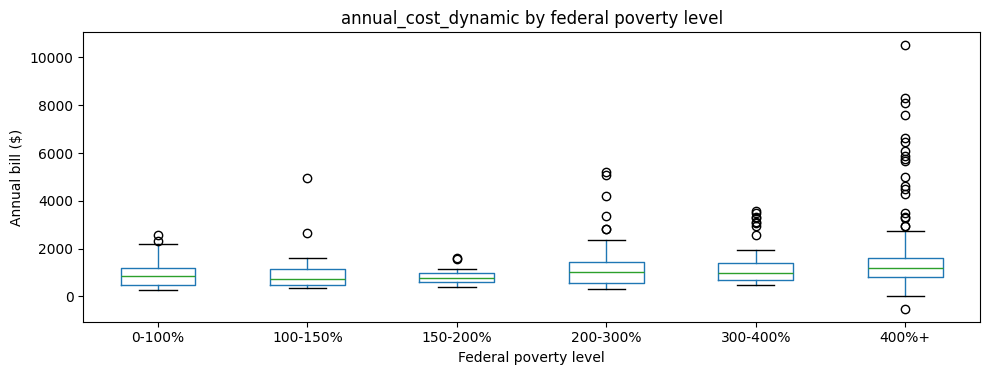

,annual_cost_flat_mean,annual_cost_flat_std,annual_cost_flat_min,annual_cost_flat_max,annual_cost_tou_mean,annual_cost_tou_std,annual_cost_tou_min,annual_cost_tou_max,annual_cost_dynamic_mean,annual_cost_dynamic_std,annual_cost_dynamic_min,annual_cost_dynamic_max
in.federal_poverty_level,,,,,,,,,,,,
0-100%,2272.318672,1324.668457,628.634165,5698.450768,2057.546644,1187.154072,579.231156,5098.108222,957.762118,595.233567,256.125523,2557.832406
100-150%,2442.041646,2168.361971,831.250174,10760.676579,2203.242205,1883.219135,752.954798,9365.988397,1041.687996,1013.772806,337.774185,4947.749404
150-200%,2071.305884,822.040395,1033.580817,3910.253017,1902.609012,765.161910,924.084840,3623.044683,840.014097,339.280205,413.024341,1603.510174
200-300%,3116.253631,2321.025802,599.230357,11059.291725,2805.001576,2011.872148,460.589950,9591.442138,1334.267592,1122.472520,311.760510,5203.660132
300-400%,3081.657330,1997.392737,1124.691687,8123.874567,2795.884042,1783.451627,1036.522117,7610.819325,1283.772875,890.698422,467.995452,3594.426254
400%+,3498.601589,2702.334405,-1769.035085,21553.729022,3161.426895,2328.748264,-1829.804863,18303.048692,1495.685633,1341.628802,-506.705094,10500.241061


Summary of annual bills by income quantile:


In [42]:
# Compare annual bills across income quartiles (distributional fairness)

if bills_with_meta is not None and "in.federal_poverty_level" in bills_with_meta.columns:
    # Filter for valid poverty level data (memory-optimized: no copy, just filter)
    df_inc = bills_with_meta[
        bills_with_meta["in.federal_poverty_level"].notna() & 
        (bills_with_meta["in.federal_poverty_level"] != "Not Available")
    ]

    if df_inc.empty:
        print("No non-missing income values; skipping income-based analysis.")
    else:
        print(f"Analyzing {len(df_inc)} buildings with valid poverty level data")
        # Define income quartiles (Q1 lowest, Q4 highest).
        # qcut can struggle if many incomes are identical; wrap in try/except.
        # List of tariff bill columns we expect
        bill_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]
        bill_cols = [c for c in bill_cols if c in df_inc.columns]

        # --- Boxplots: annual bill by income bracket for each tariff ---
        for col in bill_cols:
            plt.figure(figsize=(6, 4))
            df_inc.boxplot(
                column=col,
                by="in.federal_poverty_level",
                grid=False,
            )
            plt.title(f"{col} by federal poverty level")
            plt.suptitle("")  # remove default pandas title
            plt.xlabel("Federal poverty level")
            plt.ylabel("Annual bill ($)")
            plt.tight_layout()
            plt.show()

        # --- Numeric summary: mean, std, min, max by income quantile ---
        summary = (
            df_inc.groupby("in.federal_poverty_level")[bill_cols]
            .agg(["mean", "std", "min", "max"])
        )

        # Flatten MultiIndex columns for easier reading
        summary.columns = [
            f"{tariff}_{stat}" for tariff, stat in summary.columns

        ]        
        display(summary)

        print("Summary of annual bills by income quantile:")

### Cost per kWh
Here we examine how cost per kWh under each tariff (flat, TOU, dynamic) vary across household income levels as measured by Federal Poverty Level.  
For each poverty level category, we compare:
- **Boxplots** showing the distribution of cost per kWh under each of the three tariff structures
- **Summary statistics** (count, mean, median, std, min, max) for each tariff × poverty level combination

This analysis helps us understand whether different tariff structures create disparate impacts across income groups.

<Figure size 600x400 with 0 Axes>

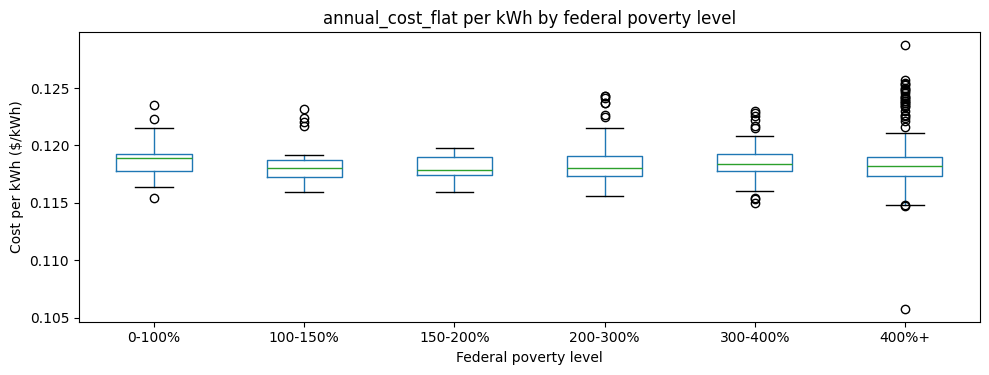

<Figure size 600x400 with 0 Axes>

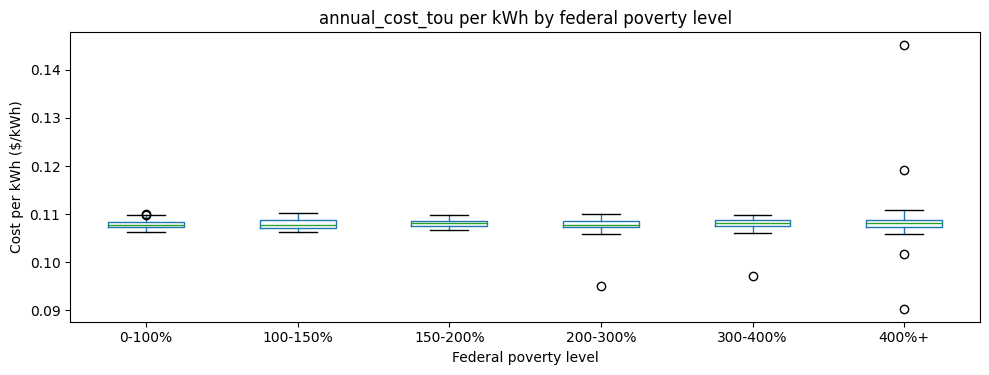

<Figure size 600x400 with 0 Axes>

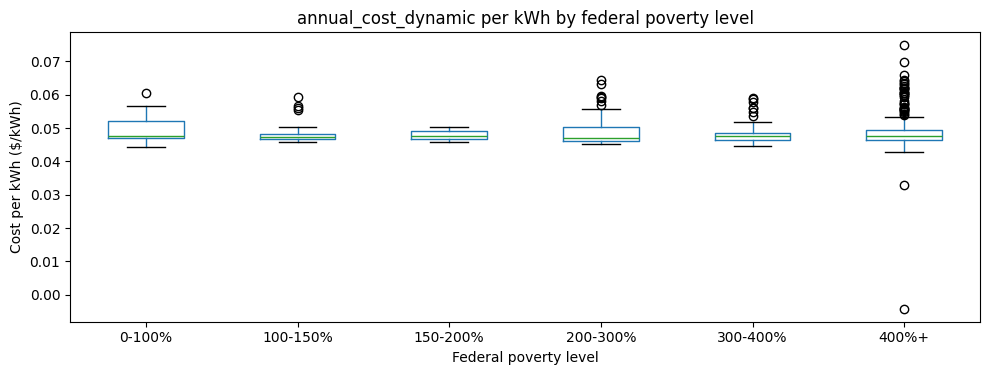

Summary of cost per kWh by income quantile:


,annual_cost_flat_per_kwh_per_kwh_mean,annual_cost_flat_per_kwh_per_kwh_std,annual_cost_flat_per_kwh_per_kwh_min,annual_cost_flat_per_kwh_per_kwh_max,annual_cost_tou_per_kwh_per_kwh_mean,annual_cost_tou_per_kwh_per_kwh_std,annual_cost_tou_per_kwh_per_kwh_min,annual_cost_tou_per_kwh_per_kwh_max,annual_cost_dynamic_per_kwh_per_kwh_mean,annual_cost_dynamic_per_kwh_per_kwh_std,annual_cost_dynamic_per_kwh_per_kwh_min,annual_cost_dynamic_per_kwh_per_kwh_max
in.federal_poverty_level,,,,,,,,,,,,
0-100%,0.118900,0.001763,0.115411,0.123481,0.107890,0.000983,0.106307,0.109972,0.049306,0.004132,0.044324,0.060481
100-150%,0.118461,0.002023,0.115941,0.123167,0.108041,0.001031,0.106386,0.110328,0.048919,0.003897,0.045829,0.059402
150-200%,0.118001,0.001125,0.115933,0.119778,0.108187,0.000874,0.106805,0.109787,0.047770,0.001420,0.045702,0.050200
200-300%,0.118727,0.002240,0.115561,0.124327,0.107703,0.001998,0.095049,0.110029,0.049323,0.004902,0.045370,0.064336
300-400%,0.118565,0.001820,0.114994,0.122989,0.107954,0.001690,0.097195,0.109923,0.048546,0.003549,0.044768,0.059130
400%+,0.118518,0.002338,0.105789,0.128708,0.108169,0.002793,0.090374,0.145071,0.048883,0.005799,-0.004112,0.074765


In [45]:
# Compute cost per kWh on-the-fly (memory-optimized: no extra columns stored)
if "annual_kwh" in df_inc.columns:
    # Create a temporary copy with per_kwh columns just for analysis
    # This avoids SettingWithCopyWarning and doesn't modify bills_with_meta
    df_per_kwh = df_inc.copy()
    
    for col in bill_cols:
        df_per_kwh[f"{col}_per_kwh"] = df_per_kwh[col] / df_per_kwh["annual_kwh"]

    # Now you can do the same summaries / boxplots but for $/kWh
    for col in bill_cols:
        plt.figure(figsize=(6, 4))
        df_per_kwh.boxplot(
            column=f"{col}_per_kwh",
            by="in.federal_poverty_level",
            grid=False,
        )
        plt.title(f"{col} per kWh by federal poverty level")
        plt.suptitle("")  # remove default pandas title
        plt.xlabel("Federal poverty level")
        plt.ylabel("Cost per kWh ($/kWh)")
        plt.tight_layout()
        plt.show()

    # Numeric summary
    summary_per_kwh = (
        df_per_kwh.groupby("in.federal_poverty_level")[
            [f"{col}_per_kwh" for col in bill_cols]
        ]
        .agg(["mean", "std", "min", "max"])
    )
    summary_per_kwh.columns = [
        f"{tariff}_per_kwh_{stat}" for tariff, stat in summary_per_kwh.columns
    ]
    print("Summary of cost per kWh by income quantile:")
    display(summary_per_kwh)
    
    # Free memory after analysis
    del df_per_kwh
else:
    print("Column 'annual_kwh' not found; cannot compute cost per kWh.")

### Tariff deltas: who wins or loses relative to flat?

Here we compute, for each household, the **difference in annual bills** under TOU and Dynamic tariffs relative to a Flat tariff (positive values = higher bills, negative values = savings).  
We examine:
- **Overall distribution** of bill differences across all buildings (histograms)
- **Winner/loser analysis**: How many buildings pay more vs. less, and by how much?
- **Distributional equity**: How bill changes vary across Federal Poverty Level categories

This analysis helps identify whether alternative tariffs create systematic winners and losers, and whether impacts are equitably distributed across income groups.

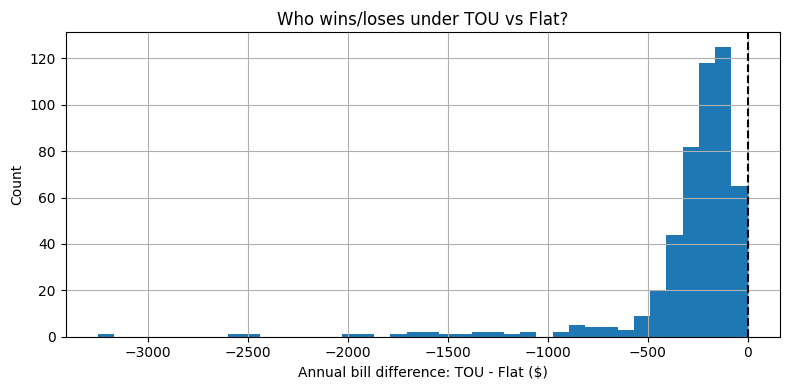

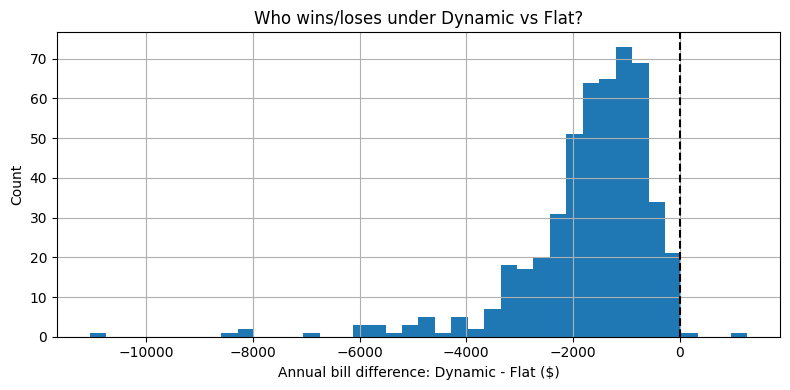


ANALYSIS: Who loses under TOU vs Flat?
Buildings that LOSE (pay more): 0 (0.0%)
Buildings that WIN (pay less): 500 (100.0%)

Winners - Annual kWh consumption:
  Mean: 24744 kWh
  Median: 21278 kWh

Winners - Bill savings (Flat - TOU):
  Mean: $281.56
  Median: $200.15

ANALYSIS: Who loses under Dynamic vs Flat?
Buildings that LOSE (pay more): 3 (0.6%)
Buildings that WIN (pay less): 497 (99.4%)

Losers - Annual kWh consumption:
  Mean: -5994 kWh
  Median: -2680 kWh

Losers - Bill increase (Dynamic - Flat):
  Mean: $519.40
  Median: $294.55
  Max: $1262.33

Winners - Annual kWh consumption:
  Mean: 24930 kWh
  Median: 21327 kWh

Winners - Bill savings (Flat - Dynamic):
  Mean: $1706.05
  Median: $1473.87


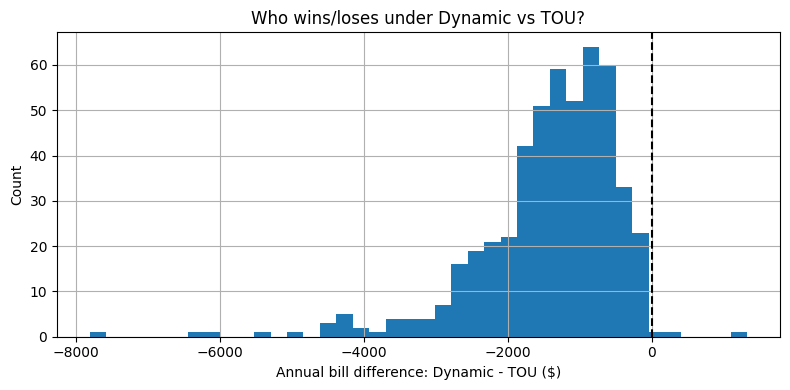


ANALYSIS: Who loses under Dynamic vs TOU?
Buildings that LOSE (pay more): 3 (0.6%)
Buildings that WIN (pay less): 497 (99.4%)

Losers - Annual kWh consumption:
  Mean: -5994 kWh
  Median: -2680 kWh

Losers - Bill increase (Dynamic - TOU):
  Mean: $575.00
  Median: $399.83
  Max: $1323.10

Winners - Annual kWh consumption:
  Mean: 24930 kWh
  Median: 21327 kWh

Winners - Bill savings (TOU - Dynamic):
  Mean: $1423.13
  Median: $1234.00


<Figure size 600x400 with 0 Axes>

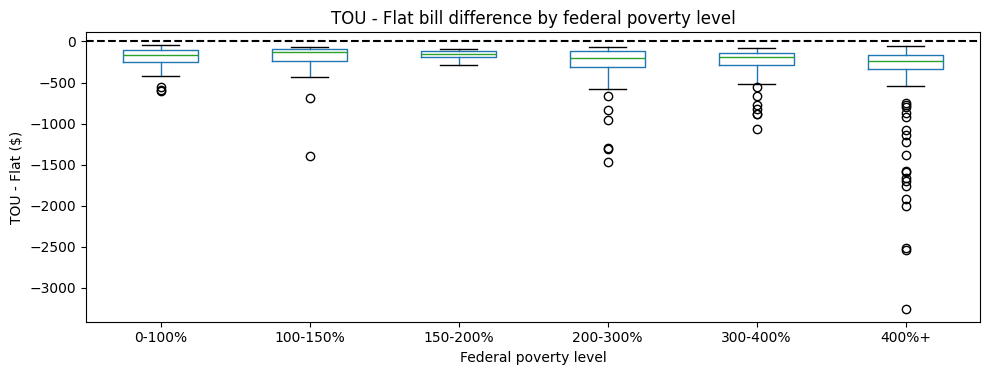


TOU - Flat bill difference by Federal Poverty Level


,Count,Mean ($),Median ($),Std ($),Min ($),Max ($)
in.federal_poverty_level,,,,,,
0-100%,36,-214.772028,-168.296017,147.129502,-600.342547,-49.403009
100-150%,23,-238.799442,-123.146316,290.870917,-1394.688182,-66.353499
150-200%,17,-168.696871,-158.858343,61.133402,-290.745934,-96.914835
200-300%,52,-311.252055,-198.253078,321.710986,-1467.849587,-71.526591
300-400%,53,-285.773288,-188.083059,232.290942,-1059.638765,-78.293747
400%+,268,-337.174694,-238.059592,393.529056,-3250.680330,-55.856788


<Figure size 600x400 with 0 Axes>

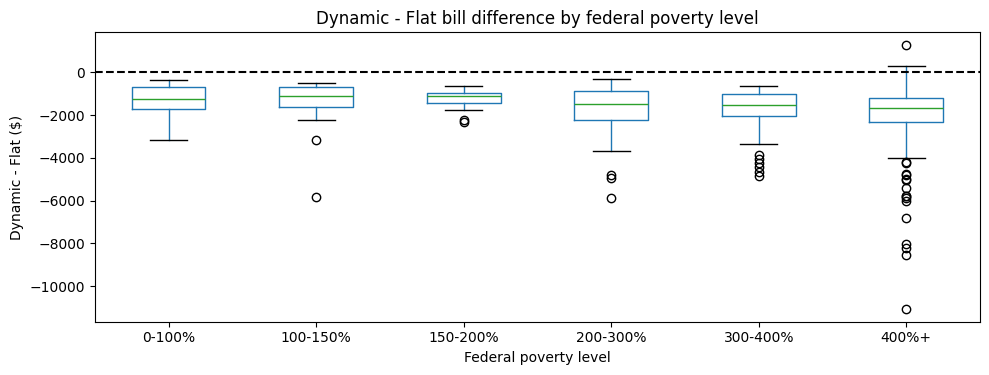


Dynamic - Flat bill difference by Federal Poverty Level


,Count,Mean ($),Median ($),Std ($),Min ($),Max ($)
in.federal_poverty_level,,,,,,
0-100%,36,-1314.556554,-1219.452661,736.935753,-3140.618362,-372.508642
100-150%,23,-1400.353650,-1087.774022,1158.433531,-5812.927175,-493.475989
150-200%,17,-1231.291787,-1112.725388,484.042052,-2338.808520,-620.556476
200-300%,52,-1781.986038,-1497.369672,1214.072028,-5855.631593,-287.469848
300-400%,53,-1797.884455,-1510.571644,1117.975669,-4836.526380,-656.696235
400%+,268,-2002.915956,-1686.099436,1381.176657,-11053.487961,1262.329991


In [55]:
# Compare annual bill differences (TOU vs Flat, Dynamic vs Flat)

if bills_with_meta is not None:
    # Ensure the needed columns exist
    needed_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]

    missing = [c for c in needed_cols if c not in bills_with_meta.columns]
    if missing:
        print("Missing bill columns, cannot compute deltas:", missing)
    else:
        # Compute deltas directly on bills_with_meta (memory-optimized: no copy)
        # Only create delta columns if they don't exist yet
        if "delta_tou_minus_flat" not in bills_with_meta.columns:
            bills_with_meta["delta_tou_minus_flat"] = (
                bills_with_meta["annual_cost_tou"] - bills_with_meta["annual_cost_flat"]
            )
        
        if "delta_dynamic_minus_flat" not in bills_with_meta.columns:
            bills_with_meta["delta_dynamic_minus_flat"] = (
                bills_with_meta["annual_cost_dynamic"] - bills_with_meta["annual_cost_flat"]
            )

        # --- Overall histogram for TOU - Flat ---
        plt.figure(figsize=(8, 4))
        bills_with_meta["delta_tou_minus_flat"].hist(bins=40)
        plt.axvline(0, color="k", linestyle="--")
        plt.xlabel("Annual bill difference: TOU - Flat ($)")
        plt.ylabel("Count")
        plt.title("Who wins/loses under TOU vs Flat?")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        bills_with_meta["delta_dynamic_minus_flat"].hist(bins=40)
        plt.axvline(0, color="k", linestyle="--")
        plt.xlabel("Annual bill difference: Dynamic - Flat ($)")
        plt.ylabel("Count")
        plt.title("Who wins/loses under Dynamic vs Flat?")
        plt.tight_layout()
        plt.show()

        # --- Analyze buildings that lose money under TOU and Dynamic ---
        
        # Buildings that lose under TOU (delta > 0 means higher bill)
        tou_losers = bills_with_meta[bills_with_meta["delta_tou_minus_flat"] > 0].copy()
        tou_winners = bills_with_meta[bills_with_meta["delta_tou_minus_flat"] <= 0].copy()
        
        print("\n" + "="*70)
        print("ANALYSIS: Who loses under TOU vs Flat?")
        print("="*70)
        print(f"Buildings that LOSE (pay more): {len(tou_losers)} ({len(tou_losers)/len(bills_with_meta)*100:.1f}%)")
        print(f"Buildings that WIN (pay less): {len(tou_winners)} ({len(tou_winners)/len(bills_with_meta)*100:.1f}%)")
        
        if len(tou_losers) > 0:
            print(f"\nLosers - Annual kWh consumption:")
            print(f"  Mean: {tou_losers['annual_kwh'].mean():.0f} kWh")
            print(f"  Median: {tou_losers['annual_kwh'].median():.0f} kWh")
            print(f"\nLosers - Bill increase (TOU - Flat):")
            print(f"  Mean: ${tou_losers['delta_tou_minus_flat'].mean():.2f}")
            print(f"  Median: ${tou_losers['delta_tou_minus_flat'].median():.2f}")
            print(f"  Max: ${tou_losers['delta_tou_minus_flat'].max():.2f}")
            
        if len(tou_winners) > 0:
            print(f"\nWinners - Annual kWh consumption:")
            print(f"  Mean: {tou_winners['annual_kwh'].mean():.0f} kWh")
            print(f"  Median: {tou_winners['annual_kwh'].median():.0f} kWh")
            print(f"\nWinners - Bill savings (Flat - TOU):")
            print(f"  Mean: ${-tou_winners['delta_tou_minus_flat'].mean():.2f}")
            print(f"  Median: ${-tou_winners['delta_tou_minus_flat'].median():.2f}")

        # Buildings that lose under Dynamic
        dynamic_losers = bills_with_meta[bills_with_meta["delta_dynamic_minus_flat"] > 0].copy()
        dynamic_winners = bills_with_meta[bills_with_meta["delta_dynamic_minus_flat"] <= 0].copy()
        
        print("\n" + "="*70)
        print("ANALYSIS: Who loses under Dynamic vs Flat?")
        print("="*70)
        print(f"Buildings that LOSE (pay more): {len(dynamic_losers)} ({len(dynamic_losers)/len(bills_with_meta)*100:.1f}%)")
        print(f"Buildings that WIN (pay less): {len(dynamic_winners)} ({len(dynamic_winners)/len(bills_with_meta)*100:.1f}%)")
        
        if len(dynamic_losers) > 0:
            print(f"\nLosers - Annual kWh consumption:")
            print(f"  Mean: {dynamic_losers['annual_kwh'].mean():.0f} kWh")
            print(f"  Median: {dynamic_losers['annual_kwh'].median():.0f} kWh")
            print(f"\nLosers - Bill increase (Dynamic - Flat):")
            print(f"  Mean: ${dynamic_losers['delta_dynamic_minus_flat'].mean():.2f}")
            print(f"  Median: ${dynamic_losers['delta_dynamic_minus_flat'].median():.2f}")
            print(f"  Max: ${dynamic_losers['delta_dynamic_minus_flat'].max():.2f}")
            
        if len(dynamic_winners) > 0:
            print(f"\nWinners - Annual kWh consumption:")
            print(f"  Mean: {dynamic_winners['annual_kwh'].mean():.0f} kWh")
            print(f"  Median: {dynamic_winners['annual_kwh'].median():.0f} kWh")
            print(f"\nWinners - Bill savings (Flat - Dynamic):")
            print(f"  Mean: ${-dynamic_winners['delta_dynamic_minus_flat'].mean():.2f}")
            print(f"  Median: ${-dynamic_winners['delta_dynamic_minus_flat'].median():.2f}")

        # --- Analyze buildings that lose/win under Dynamic vs TOU ---
        
        # Compute delta for Dynamic vs TOU
        if "delta_dynamic_minus_tou" not in bills_with_meta.columns:
            bills_with_meta["delta_dynamic_minus_tou"] = (
                bills_with_meta["annual_cost_dynamic"] - bills_with_meta["annual_cost_tou"]
            )
        
        # Histogram for Dynamic - TOU
        plt.figure(figsize=(8, 4))
        bills_with_meta["delta_dynamic_minus_tou"].hist(bins=40)
        plt.axvline(0, color="k", linestyle="--")
        plt.xlabel("Annual bill difference: Dynamic - TOU ($)")
        plt.ylabel("Count")
        plt.title("Who wins/loses under Dynamic vs TOU?")
        plt.tight_layout()
        plt.show()
        
        # Buildings that lose under Dynamic vs TOU (delta > 0 means higher bill)
        dynamic_tou_losers = bills_with_meta[bills_with_meta["delta_dynamic_minus_tou"] > 0].copy()
        dynamic_tou_winners = bills_with_meta[bills_with_meta["delta_dynamic_minus_tou"] <= 0].copy()
        
        print("\n" + "="*70)
        print("ANALYSIS: Who loses under Dynamic vs TOU?")
        print("="*70)
        print(f"Buildings that LOSE (pay more): {len(dynamic_tou_losers)} ({len(dynamic_tou_losers)/len(bills_with_meta)*100:.1f}%)")
        print(f"Buildings that WIN (pay less): {len(dynamic_tou_winners)} ({len(dynamic_tou_winners)/len(bills_with_meta)*100:.1f}%)")
        
        if len(dynamic_tou_losers) > 0:
            print(f"\nLosers - Annual kWh consumption:")
            print(f"  Mean: {dynamic_tou_losers['annual_kwh'].mean():.0f} kWh")
            print(f"  Median: {dynamic_tou_losers['annual_kwh'].median():.0f} kWh")
            print(f"\nLosers - Bill increase (Dynamic - TOU):")
            print(f"  Mean: ${dynamic_tou_losers['delta_dynamic_minus_tou'].mean():.2f}")
            print(f"  Median: ${dynamic_tou_losers['delta_dynamic_minus_tou'].median():.2f}")
            print(f"  Max: ${dynamic_tou_losers['delta_dynamic_minus_tou'].max():.2f}")
            
        if len(dynamic_tou_winners) > 0:
            print(f"\nWinners - Annual kWh consumption:")
            print(f"  Mean: {dynamic_tou_winners['annual_kwh'].mean():.0f} kWh")
            print(f"  Median: {dynamic_tou_winners['annual_kwh'].median():.0f} kWh")
            print(f"\nWinners - Bill savings (TOU - Dynamic):")
            print(f"  Mean: ${-dynamic_tou_winners['delta_dynamic_minus_tou'].mean():.2f}")
            print(f"  Median: ${-dynamic_tou_winners['delta_dynamic_minus_tou'].median():.2f}")

        # --- Difference by income quantile ---

        if "in.federal_poverty_level" in bills_with_meta.columns:
            # Filter out "Not Available" values for cleaner plots (capital A)
            df_filtered = bills_with_meta[
                (bills_with_meta["in.federal_poverty_level"].notna()) &
                (bills_with_meta["in.federal_poverty_level"] != "Not Available")
            ]
            
            if not df_filtered.empty:
                plt.figure(figsize=(6, 4))
                df_filtered.boxplot(
                    column="delta_tou_minus_flat",
                    by="in.federal_poverty_level",
                    grid=False,
                )
                plt.axhline(0, color="k", linestyle="--")
                plt.title("TOU - Flat bill difference by federal poverty level")
                plt.suptitle("")
                plt.xlabel("Federal poverty level")
                plt.ylabel("TOU - Flat ($)")
                plt.tight_layout()
                plt.show()
                
                # Print statistics for TOU by poverty level
                print("\n" + "="*70)
                print("TOU - Flat bill difference by Federal Poverty Level")
                print("="*70)
                tou_stats = df_filtered.groupby("in.federal_poverty_level")["delta_tou_minus_flat"].agg([
                    'count', 'mean', 'median', 'std', 'min', 'max'
                ])
                tou_stats.columns = ['Count', 'Mean ($)', 'Median ($)', 'Std ($)', 'Min ($)', 'Max ($)']
                display(tou_stats)
            
                plt.figure(figsize=(6, 4))
                df_filtered.boxplot(
                    column="delta_dynamic_minus_flat",
                    by="in.federal_poverty_level",
                    grid=False,
                )
                plt.axhline(0, color="k", linestyle="--")
                plt.title("Dynamic - Flat bill difference by federal poverty level")
                plt.suptitle("")
                plt.xlabel("Federal poverty level")
                plt.ylabel("Dynamic - Flat ($)")
                plt.tight_layout()
                plt.show()
                
                # Print statistics for Dynamic by poverty level
                print("\n" + "="*70)
                print("Dynamic - Flat bill difference by Federal Poverty Level")
                print("="*70)
                dynamic_stats = df_filtered.groupby("in.federal_poverty_level")["delta_dynamic_minus_flat"].agg([
                    'count', 'mean', 'median', 'std', 'min', 'max'
                ])
                dynamic_stats.columns = ['Count', 'Mean ($)', 'Median ($)', 'Std ($)', 'Min ($)', 'Max ($)']
                display(dynamic_stats)

### Diagnostic: Understanding Tenure and PUMA Metro Status in the Dataset

Before analyzing bills by tenure and metro status, let's explore what values these attributes take and how many buildings fall into each category.

In [ ]:
# Diagnostic: Explore PUMA Metro Status attribute
if bills_with_meta is not None and "in.puma_metro_status" in bills_with_meta.columns:
    print("=== PUMA METRO STATUS ATTRIBUTE ===")
    print(f"\nUnique values in 'in.puma_metro_status':")
    print(bills_with_meta["in.puma_metro_status"].value_counts(dropna=False))
    
    print(f"\nTotal buildings: {len(bills_with_meta)}")
    print(f"Buildings with valid metro status data: {bills_with_meta['in.puma_metro_status'].notna().sum()}")
    print(f"Buildings with missing metro status data: {bills_with_meta['in.puma_metro_status'].isna().sum()}")
else:
    print("'in.puma_metro_status' column not found in bills_with_meta")

=== PUMA METRO STATUS ATTRIBUTE ===

Unique values in 'in.puma_metro_status':
in.puma_metro_status
In metro area, not/partially in principal city    408
In metro area, principal city                      63
Not/partially in metro area                        29
Name: count, dtype: int64

Total buildings: 500
Buildings with valid metro status data: 500
Buildings with missing metro status data: 0


In [ ]:
# Diagnostic: Explore Tenure attribute
if bills_with_meta is not None and "in.tenure" in bills_with_meta.columns:
    print("=== TENURE ATTRIBUTE ===")
    print(f"\nUnique values in 'in.tenure':")
    print(bills_with_meta["in.tenure"].value_counts(dropna=False))
    
    print(f"\nTotal buildings: {len(bills_with_meta)}")
    print(f"Buildings with valid tenure data: {bills_with_meta['in.tenure'].notna().sum()}")
    print(f"Buildings with missing tenure data: {bills_with_meta['in.tenure'].isna().sum()}")
else:
    print("'in.tenure' column not found in bills_with_meta")

=== TENURE ATTRIBUTE ===

Unique values in 'in.tenure':
in.tenure
Owner            287
Renter           162
Not Available     51
Name: count, dtype: int64

Total buildings: 500
Buildings with valid tenure data: 500
Buildings with missing tenure data: 0


### Bills by PUMA Metro Status (Urban vs Suburban/Rural equity check)

Here we examine how annual bills under each tariff (flat, TOU, dynamic) vary across different metropolitan area classifications.  
For each metro status category, we compare:
- **Boxplots** showing the distribution of annual bills under each of the three tariff structures
- **Summary statistics** (count, mean, median, std, min, max) for each tariff × metro status combination

This analysis helps us understand whether different tariff structures create disparate impacts across urban, suburban, and rural households.

Analyzing 500 buildings with valid metro status data


<Figure size 800x400 with 0 Axes>

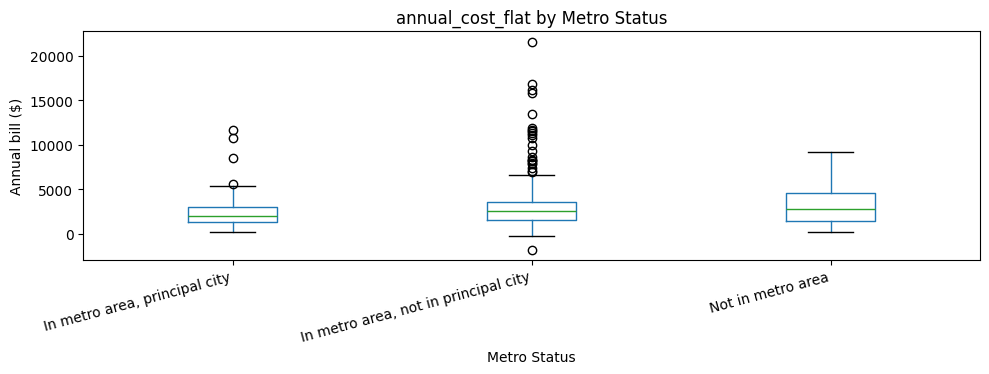

<Figure size 800x400 with 0 Axes>

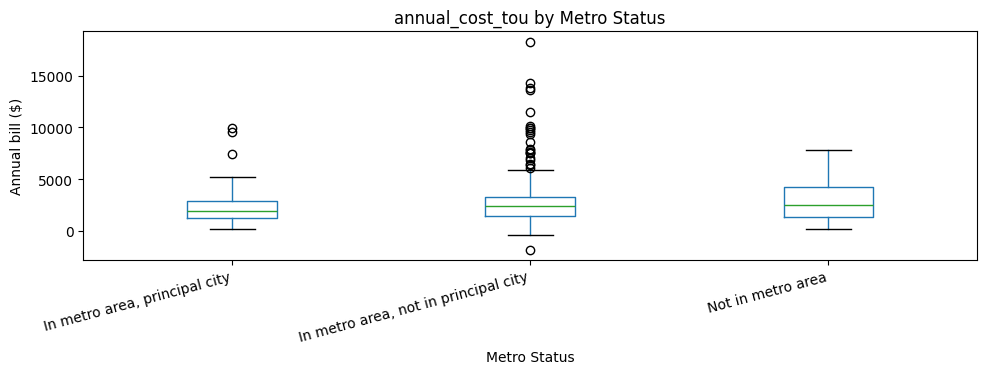

<Figure size 800x400 with 0 Axes>

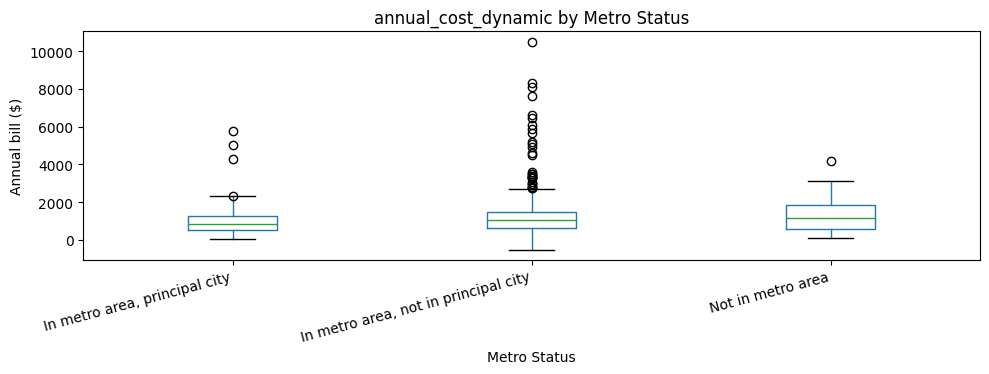


Summary of annual bills by metro status:


C:\Users\Manny\AppData\Local\Temp\ipykernel_67700\3388263909.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_metro.groupby("metro_status_clean")[bill_cols]


,annual_cost_flat_count,annual_cost_flat_mean,annual_cost_flat_median,annual_cost_flat_std,annual_cost_flat_min,annual_cost_flat_max,annual_cost_tou_count,annual_cost_tou_mean,annual_cost_tou_median,annual_cost_tou_std,annual_cost_tou_min,annual_cost_tou_max,annual_cost_dynamic_count,annual_cost_dynamic_mean,annual_cost_dynamic_median,annual_cost_dynamic_std,annual_cost_dynamic_min,annual_cost_dynamic_max
metro_status_clean,,,,,,,,,,,,,,,,,,
"In metro area, principal city",63,2583.940469,2036.602385,2163.777546,209.502710,11609.832518,63,2340.657283,1870.519733,1896.860689,199.852425,9942.229319,63,1110.229963,834.550557,1036.137151,75.589192,5750.314643
"In metro area, not in principal city",408,2996.116148,2555.704552,2501.604495,-1769.035085,21553.729022,408,2709.034956,2339.505570,2172.518696,-1829.804863,18303.048692,408,1277.718630,1035.012587,1213.912739,-506.705094,10500.241061
Not in metro area,29,3130.415442,2828.256012,2266.668228,205.892284,9126.054375,29,2843.436956,2523.023930,2003.264713,197.528465,7825.453548,29,1323.522854,1137.194374,961.066511,94.848522,4182.416020


In [54]:
# Compare annual bills across metro status categories (urban/suburban/rural equity)

if bills_with_meta is not None and "in.puma_metro_status" in bills_with_meta.columns:
    # Filter for valid metro status data
    df_metro = bills_with_meta[
        bills_with_meta["in.puma_metro_status"].notna()
    ].copy()

    if df_metro.empty:
        print("No valid metro status values; skipping metro-based analysis.")
    else:
        print(f"Analyzing {len(df_metro)} buildings with valid metro status data")
        
        # Relabel metro status categories for clarity
        metro_label_map = {
            "In metro area, principal city": "In metro area, principal city",
            "In metro area, not/partially in principal city": "In metro area, not in principal city",
            "Not/partially in metro area": "Not in metro area"
        }
        df_metro["metro_status_clean"] = df_metro["in.puma_metro_status"].map(metro_label_map)
        
        # Define the desired order for categories
        metro_order = [
            "In metro area, principal city",
            "In metro area, not in principal city",
            "Not in metro area"
        ]
        df_metro["metro_status_clean"] = pd.Categorical(
            df_metro["metro_status_clean"], 
            categories=metro_order, 
            ordered=True
        )
        
        # List of tariff bill columns we expect
        bill_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]
        bill_cols = [c for c in bill_cols if c in df_metro.columns]

        # --- Boxplots: annual bill by metro status for each tariff ---
        for col in bill_cols:
            plt.figure(figsize=(8, 4))
            df_metro.boxplot(
                column=col,
                by="metro_status_clean",
                grid=False,
            )
            plt.title(f"{col} by Metro Status")
            plt.suptitle("")  # remove default pandas title
            plt.xlabel("Metro Status")
            plt.ylabel("Annual bill ($)")
            plt.xticks(rotation=15, ha='right')  # Rotate labels for readability
            plt.tight_layout()
            plt.show()

        # --- Numeric summary: mean, std, min, max by metro status ---
        summary_metro = (
            df_metro.groupby("metro_status_clean")[bill_cols]
            .agg(["count", "mean", "median", "std", "min", "max"])
        )

        # Flatten MultiIndex columns for easier reading
        summary_metro.columns = [
            f"{tariff}_{stat}" for tariff, stat in summary_metro.columns
        ]
        
        print("\nSummary of annual bills by metro status:")
        display(summary_metro)
else:
    print("bills_with_meta is None or missing 'in.puma_metro_status' column")

### Bills by Tenure (Owner vs Renter equity check)

Here we examine how annual bills under each tariff (flat, TOU, dynamic) vary between homeowners and renters.  
For each tenure category, we compare:
- **Boxplots** showing the distribution of annual bills under each of the three tariff structures
- **Summary statistics** (count, mean, median, std, min, max) for each tariff × tenure combination

This analysis helps us understand whether different tariff structures create disparate impacts between owners and renters.

Analyzing 449 buildings with valid tenure data


<Figure size 600x400 with 0 Axes>

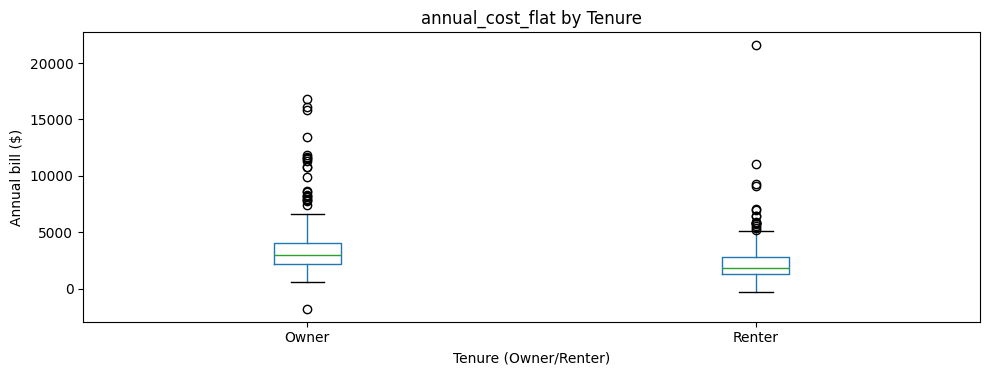

<Figure size 600x400 with 0 Axes>

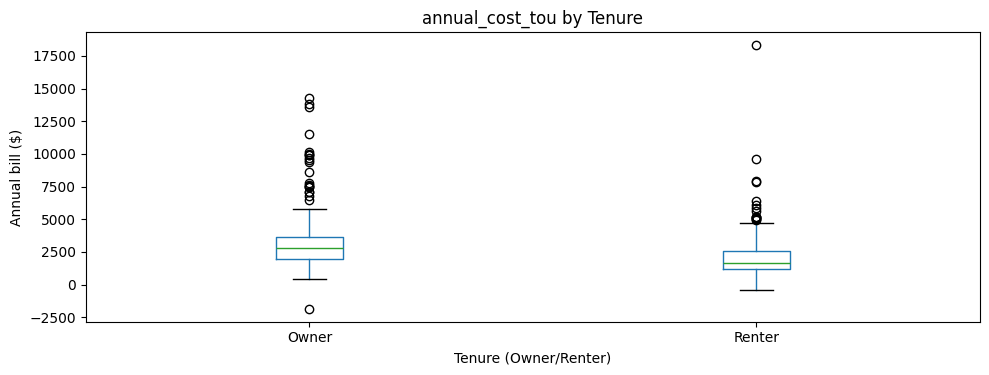

<Figure size 600x400 with 0 Axes>

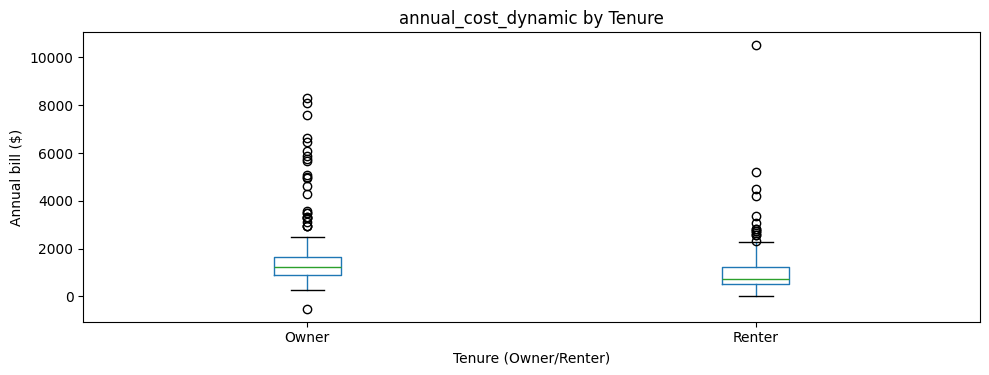


Summary of annual bills by tenure:


,annual_cost_flat_count,annual_cost_flat_mean,annual_cost_flat_median,annual_cost_flat_std,annual_cost_flat_min,annual_cost_flat_max,annual_cost_tou_count,annual_cost_tou_mean,annual_cost_tou_median,annual_cost_tou_std,annual_cost_tou_min,annual_cost_tou_max,annual_cost_dynamic_count,annual_cost_dynamic_mean,annual_cost_dynamic_median,annual_cost_dynamic_std,annual_cost_dynamic_min,annual_cost_dynamic_max
in.tenure,,,,,,,,,,,,,,,,,,
Owner,287,3560.558631,3015.368264,2463.308778,-1769.035085,16842.005710,287,3223.695297,2793.034907,2133.530332,-1829.804863,14309.132596,287,1515.709709,1224.954250,1222.113219,-506.705094,8306.186915
Renter,162,2557.410839,1854.108700,2309.717784,-283.530605,21553.729022,162,2303.669116,1689.718007,1993.703243,-388.811582,18303.048692,162,1086.268149,741.341903,1099.767623,11.021071,10500.241061


In [50]:
# Compare annual bills across tenure categories (owner vs renter equity)

if bills_with_meta is not None and "in.tenure" in bills_with_meta.columns:
    # Filter for valid tenure data (exclude "Not Available")
    df_tenure = bills_with_meta[
        bills_with_meta["in.tenure"].notna() & 
        (bills_with_meta["in.tenure"] != "Not Available")
    ]

    if df_tenure.empty:
        print("No valid tenure values; skipping tenure-based analysis.")
    else:
        print(f"Analyzing {len(df_tenure)} buildings with valid tenure data")
        
        # List of tariff bill columns we expect
        bill_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]
        bill_cols = [c for c in bill_cols if c in df_tenure.columns]

        # --- Boxplots: annual bill by tenure for each tariff ---
        for col in bill_cols:
            plt.figure(figsize=(6, 4))
            df_tenure.boxplot(
                column=col,
                by="in.tenure",
                grid=False,
            )
            plt.title(f"{col} by Tenure")
            plt.suptitle("")  # remove default pandas title
            plt.xlabel("Tenure (Owner/Renter)")
            plt.ylabel("Annual bill ($)")
            plt.tight_layout()
            plt.show()

        # --- Numeric summary: mean, std, min, max by tenure ---
        summary_tenure = (
            df_tenure.groupby("in.tenure")[bill_cols]
            .agg(["count", "mean", "median", "std", "min", "max"])
        )

        # Flatten MultiIndex columns for easier reading
        summary_tenure.columns = [
            f"{tariff}_{stat}" for tariff, stat in summary_tenure.columns
        ]
        
        print("\nSummary of annual bills by tenure:")
        display(summary_tenure)
else:
    print("bills_with_meta is None or missing 'in.tenure' column")

### Energy Bill Burden Analysis: Percentage of Income Spent on Utilities (PIU)

Energy bill burden, measured as the **Percentage of Income spent on Utilities (PIU)**, is a critical equity metric that reveals whether energy costs are affordable relative to household income.  

In this section, we compute PIU for each building under each tariff structure (flat, TOU, dynamic) by dividing annual electricity bills by representative household income.  

We examine:
- **PIU distribution** across income levels: How does the share of income spent on electricity vary between low-income and high-income households?
- **Tariff impact on burden**: Do different tariff structures (flat, TOU, dynamic) shift the burden differently across income groups?
- **Equity implications**: Are low-income households disproportionately burdened by electricity costs?

**Key metric**: PIU (%) = (Annual Electricity Bill / Annual Household Income) × 100

High PIU values (typically >6% for energy, >3% for electricity alone) indicate energy insecurity and potential hardship.

In [56]:
# Diagnostic: Explore representative income data structure

if bills_with_meta is not None and "in.representative_income" in bills_with_meta.columns:
    print("=== REPRESENTATIVE INCOME ATTRIBUTE ===")
    print(f"\nColumn name: 'in.representative_income'")
    print(f"Data type: {bills_with_meta['in.representative_income'].dtype}")
    print(f"\nSample values (first 20):")
    print(bills_with_meta["in.representative_income"].head(20).tolist())
    
    print(f"\nBasic statistics:")
    print(bills_with_meta["in.representative_income"].describe())
    
    print(f"\nUnique values count: {bills_with_meta['in.representative_income'].nunique()}")
    print(f"Missing values: {bills_with_meta['in.representative_income'].isna().sum()}")
    
    print(f"\nValue distribution (top 20 most common):")
    print(bills_with_meta["in.representative_income"].value_counts(dropna=False).head(20))
    
    # Check if this is numeric or categorical
    print(f"\nData appears to be: ", end="")
    if pd.api.types.is_numeric_dtype(bills_with_meta["in.representative_income"]):
        print("NUMERIC (actual dollar values)")
    else:
        print("CATEGORICAL (income ranges or codes)")
        
else:
    print("'in.representative_income' column not found in bills_with_meta")
    print("\nAvailable income-related columns:")
    income_cols = [c for c in bills_with_meta.columns if 'income' in c.lower()]
    for col in income_cols:
        print(f"  - {col}")

=== REPRESENTATIVE INCOME ATTRIBUTE ===

Column name: 'in.representative_income'
Data type: float32

Sample values (first 20):
[187720.0, 131826.0, 110208.0, 172335.0, 421383.0, 89736.0, 121217.0, nan, 113357.0, nan, 129657.0, 56184.0, 75193.0, 234552.0, 67045.0, 129775.0, 191622.0, 172826.0, 61887.0, 169603.0]

Basic statistics:
count       449.000000
mean     113527.085938
std       90390.070312
min           1.000000
25%       47661.000000
50%       89943.000000
75%      150283.000000
max      500032.000000
Name: in.representative_income, dtype: float64

Unique values count: 385
Missing values: 51

Value distribution (top 20 most common):
in.representative_income
NaN         51
64828.0      4
364119.0     4
61887.0      4
38644.0      4
1.0          3
110208.0     3
32414.0      3
292970.0     3
89642.0      3
89903.0      3
88587.0      3
128814.0     3
262638.0     3
166392.0     3
90913.0      3
150283.0     3
5153.0       2
27419.0      2
126552.0     2
Name: count, dtype: int64

In [68]:
# Compute PIU (Percentage of Income spent on Utilities) for each tariff

if bills_with_meta is not None:
    # Check if we have both income and bill data
    required_cols = ["in.representative_income", "annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]
    missing = [c for c in required_cols if c not in bills_with_meta.columns]
    
    if missing:
        print(f"Missing required columns: {missing}")
    else:
        # Filter to buildings with valid income data (exclude NaN and very low incomes)
        # Filter out incomes below $1000 as they're likely data errors
        df_piu = bills_with_meta[
            (bills_with_meta["in.representative_income"].notna()) &
            (bills_with_meta["in.representative_income"] > 1000)
        ].copy()
        
        print(f"Computing PIU for {len(df_piu)} buildings with valid income data")
        print(f"(Excluded {len(bills_with_meta) - len(df_piu)} buildings with missing or invalid income)")
        
        # Compute PIU for each tariff (as percentage)
        df_piu["piu_flat"] = (df_piu["annual_cost_flat"] / df_piu["in.representative_income"]) * 100
        df_piu["piu_tou"] = (df_piu["annual_cost_tou"] / df_piu["in.representative_income"]) * 100
        df_piu["piu_dynamic"] = (df_piu["annual_cost_dynamic"] / df_piu["in.representative_income"]) * 100
        
        # Filter out buildings with negative PIU (invalid data - likely negative bills)
        piu_cols = ["piu_flat", "piu_tou", "piu_dynamic"]
        before_filter = len(df_piu)
        df_piu = df_piu[
            (df_piu["piu_flat"] >= 0) &
            (df_piu["piu_tou"] >= 0) &
            (df_piu["piu_dynamic"] >= 0)
        ].copy()
        removed = before_filter - len(df_piu)
        if removed > 0:
            print(f"Removed {removed} buildings with negative PIU values")
        
        # Summary statistics for PIU
        print("\n=== PIU Summary Statistics (%) ===")
        piu_summary = df_piu[piu_cols].describe()
        display(piu_summary)
        
        # Count buildings with high energy burden (>6% for total energy, using >3% for electricity only)
        print("\n=== Energy Burden Thresholds ===")
        for col in piu_cols:
            tariff_name = col.replace("piu_", "").upper()
            high_burden = (df_piu[col] > 3.0).sum()
            pct = (high_burden / len(df_piu)) * 100
            print(f"{tariff_name}: {high_burden} buildings ({pct:.1f}%) with PIU > 3%")
            
            very_high_burden = (df_piu[col] > 6.0).sum()
            pct_vh = (very_high_burden / len(df_piu)) * 100
            print(f"{tariff_name}: {very_high_burden} buildings ({pct_vh:.1f}%) with PIU > 6%")
        
        # Store df_piu for use in subsequent cells
        print(f"\ndf_piu created with shape: {df_piu.shape}")
else:
    print("bills_with_meta is None; cannot compute PIU")

Computing PIU for 445 buildings with valid income data
(Excluded 55 buildings with missing or invalid income)
Removed 2 buildings with negative PIU values

=== PIU Summary Statistics (%) ===


,piu_flat,piu_tou,piu_dynamic
count,443.000000,443.000000,443.000000
mean,6.348611,5.755210,2.678648
std,14.029153,12.934898,6.016065
min,0.202168,0.184779,0.081209
25%,1.759527,1.614174,0.709968
50%,2.948044,2.716190,1.184336
75%,5.641787,5.146946,2.403019
max,232.529202,218.185392,99.723989



=== Energy Burden Thresholds ===
FLAT: 218 buildings (49.2%) with PIU > 3%
FLAT: 105 buildings (23.7%) with PIU > 6%
TOU: 201 buildings (45.4%) with PIU > 3%
TOU: 92 buildings (20.8%) with PIU > 6%
DYNAMIC: 88 buildings (19.9%) with PIU > 3%
DYNAMIC: 40 buildings (9.0%) with PIU > 6%

df_piu created with shape: (443, 781)


Analyzing PIU for 443 buildings across poverty levels


<Figure size 800x500 with 0 Axes>

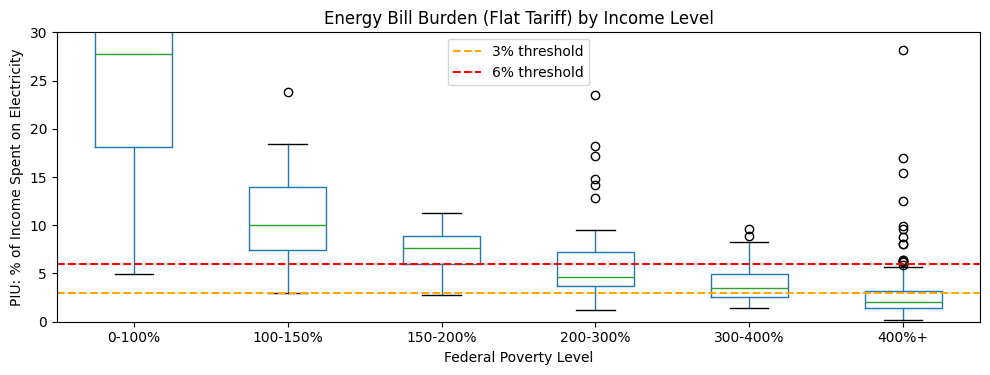

<Figure size 800x500 with 0 Axes>

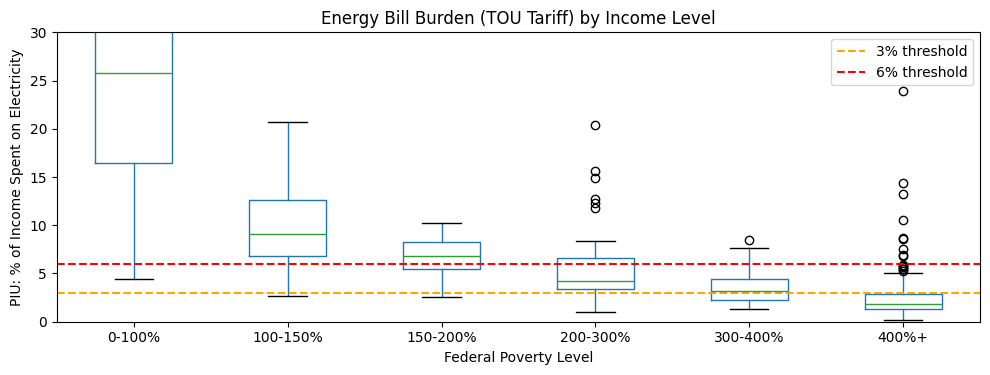

<Figure size 800x500 with 0 Axes>

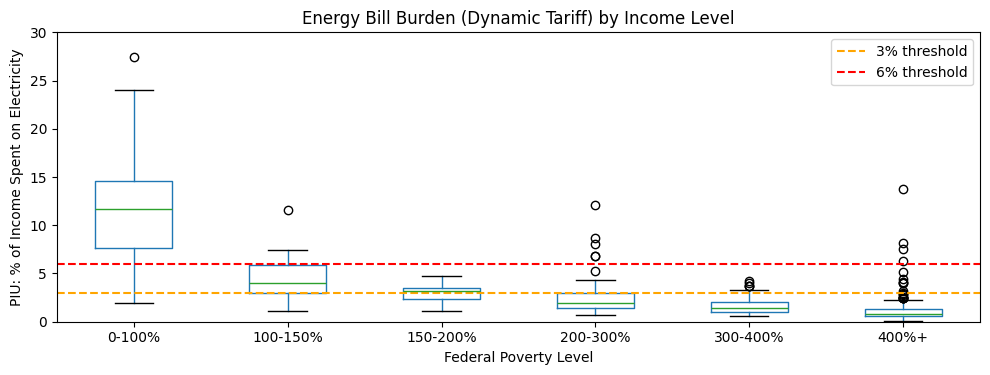


=== PIU by Federal Poverty Level: Summary Statistics ===


,piu_flat_count,piu_flat_mean,piu_flat_median,piu_flat_std,piu_flat_min,piu_flat_max,piu_tou_count,piu_tou_mean,piu_tou_median,piu_tou_std,piu_tou_min,piu_tou_max,piu_dynamic_count,piu_dynamic_mean,piu_dynamic_median,piu_dynamic_std,piu_dynamic_min,piu_dynamic_max
in.federal_poverty_level,,,,,,,,,,,,,,,,,,
0-100%,32,34.708261,27.755578,39.093611,4.967398,232.529202,32,31.649306,25.798387,36.687507,4.443722,218.185392,32,14.504139,11.663562,16.705085,1.985657,99.723989
100-150%,23,13.745174,10.007152,15.988920,2.948044,83.539140,23,12.376595,9.081821,13.856280,2.681419,72.711656,23,5.884490,4.010849,7.451398,1.161207,38.411221
150-200%,17,7.497998,7.597158,2.217902,2.808393,11.241918,17,6.883396,6.858069,2.065113,2.587273,10.247460,17,3.040496,3.142866,0.922402,1.117396,4.700450
200-300%,52,6.250716,4.601518,4.524878,1.257276,23.489668,52,5.622251,4.207275,3.904869,0.966388,20.397921,52,2.677607,1.961933,2.232126,0.654121,12.082315
300-400%,53,4.113648,3.520953,2.130907,1.423914,9.582865,53,3.731225,3.159645,1.887016,1.279823,8.512016,53,1.715187,1.386579,0.981416,0.557261,4.232795
400%+,266,2.688364,2.041783,2.596057,0.202168,28.151258,266,2.424770,1.878168,2.229280,0.184779,23.905554,266,1.147881,0.850825,1.260569,0.081209,13.714332



=== High Energy Burden (>6% PIU) by Poverty Level ===

Flat Tariff:
  400%+: 14/266 buildings (5.3%)
  300-400%: 11/53 buildings (20.8%)
  200-300%: 20/52 buildings (38.5%)
  150-200%: 11/17 buildings (64.7%)
  0-100%: 31/32 buildings (96.9%)
  100-150%: 18/23 buildings (78.3%)

TOU Tariff:
  400%+: 9/266 buildings (3.4%)
  300-400%: 8/53 buildings (15.1%)
  200-300%: 17/52 buildings (32.7%)
  150-200%: 10/17 buildings (58.8%)
  0-100%: 30/32 buildings (93.8%)
  100-150%: 18/23 buildings (78.3%)

Dynamic Tariff:
  400%+: 4/266 buildings (1.5%)
  300-400%: 0/53 buildings (0.0%)
  200-300%: 5/52 buildings (9.6%)
  150-200%: 0/17 buildings (0.0%)
  0-100%: 26/32 buildings (81.2%)
  100-150%: 5/23 buildings (21.7%)


In [71]:
# PIU by Federal Poverty Level: Boxplots showing burden distribution

if 'df_piu' in locals() and "in.federal_poverty_level" in df_piu.columns:
    # Filter out "Not Available" poverty levels
    df_piu_poverty = df_piu[
        (df_piu["in.federal_poverty_level"].notna()) &
        (df_piu["in.federal_poverty_level"] != "Not Available")
    ]
    
    if df_piu_poverty.empty:
        print("No valid poverty level data for PIU analysis")
    else:
        print(f"Analyzing PIU for {len(df_piu_poverty)} buildings across poverty levels")
        
        piu_cols = ["piu_flat", "piu_tou", "piu_dynamic"]
        tariff_labels = {"piu_flat": "Flat", "piu_tou": "TOU", "piu_dynamic": "Dynamic"}
        
        # Create boxplots for each tariff
        for col in piu_cols:
            plt.figure(figsize=(8, 5))
            df_piu_poverty.boxplot(
                column=col,
                by="in.federal_poverty_level",
                grid=False,
            )
            plt.axhline(3.0, color="orange", linestyle="--", linewidth=1.5, label="3% threshold")
            plt.axhline(6.0, color="red", linestyle="--", linewidth=1.5, label="6% threshold")
            plt.title(f"Energy Bill Burden ({tariff_labels[col]} Tariff) by Income Level")
            plt.suptitle("")
            plt.xlabel("Federal Poverty Level")
            plt.ylabel("PIU: % of Income Spent on Electricity")
            plt.legend()
            # Set y-axis to 30% to show upper tails of low-income boxes
            plt.ylim(0, 30)
            plt.tight_layout()
            plt.show()
        
        # Summary statistics table
        print("\n=== PIU by Federal Poverty Level: Summary Statistics ===")
        piu_by_poverty = df_piu_poverty.groupby("in.federal_poverty_level")[piu_cols].agg([
            'count', 'mean', 'median', 'std', 'min', 'max'
        ])
        piu_by_poverty.columns = [f"{col}_{stat}" for col, stat in piu_by_poverty.columns]
        display(piu_by_poverty)
        
        # Count high-burden buildings by poverty level
        print("\n=== High Energy Burden (>6% PIU) by Poverty Level ===")
        for col in piu_cols:
            tariff_name = tariff_labels[col]
            high_burden_by_poverty = df_piu_poverty[df_piu_poverty[col] > 6.0].groupby("in.federal_poverty_level").size()
            total_by_poverty = df_piu_poverty.groupby("in.federal_poverty_level").size()
            pct_by_poverty = (high_burden_by_poverty / total_by_poverty * 100).fillna(0)
            
            print(f"\n{tariff_name} Tariff:")
            for poverty_level in df_piu_poverty["in.federal_poverty_level"].unique():
                count = high_burden_by_poverty.get(poverty_level, 0)
                total = total_by_poverty.get(poverty_level, 0)
                pct = pct_by_poverty.get(poverty_level, 0)
                print(f"  {poverty_level}: {count}/{total} buildings ({pct:.1f}%)")
else:
    print("df_piu not available or missing poverty level data")

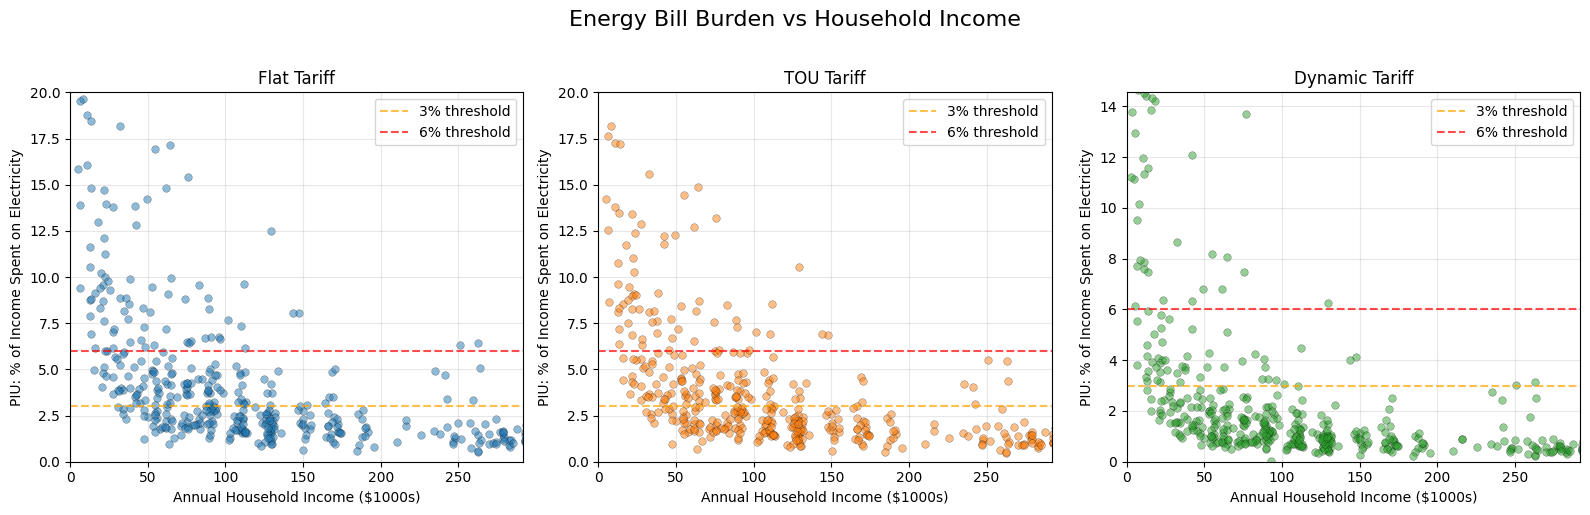


=== Correlation: Income vs PIU ===
Flat: -0.3200 (negative = burden decreases as income increases)
TOU: -0.3153 (negative = burden decreases as income increases)
Dynamic: -0.3128 (negative = burden decreases as income increases)


In [59]:
# PIU vs Income: Scatter plot showing inverse relationship between income and burden

if 'df_piu' in locals():
    # Create scatter plots for each tariff
    piu_cols = ["piu_flat", "piu_tou", "piu_dynamic"]
    tariff_labels = {"piu_flat": "Flat", "piu_tou": "TOU", "piu_dynamic": "Dynamic"}
    colors = {"piu_flat": "#1f77b4", "piu_tou": "#ff7f0e", "piu_dynamic": "#2ca02c"}
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for idx, col in enumerate(piu_cols):
        ax = axes[idx]
        
        # Scatter plot with transparency
        ax.scatter(
            df_piu["in.representative_income"] / 1000,  # Convert to thousands for readability
            df_piu[col],
            alpha=0.5,
            s=30,
            color=colors[col],
            edgecolors='black',
            linewidth=0.3
        )
        
        # Add threshold lines
        ax.axhline(3.0, color="orange", linestyle="--", linewidth=1.5, label="3% threshold", alpha=0.7)
        ax.axhline(6.0, color="red", linestyle="--", linewidth=1.5, label="6% threshold", alpha=0.7)
        
        ax.set_xlabel("Annual Household Income ($1000s)")
        ax.set_ylabel("PIU: % of Income Spent on Electricity")
        ax.set_title(f"{tariff_labels[col]} Tariff")
        ax.set_ylim(0, min(20, df_piu[col].quantile(0.98)))  # Cap at 20% or 98th percentile
        ax.set_xlim(0, df_piu["in.representative_income"].quantile(0.95) / 1000)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Energy Bill Burden vs Household Income", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Compute correlation between income and PIU
    print("\n=== Correlation: Income vs PIU ===")
    for col in piu_cols:
        tariff_name = tariff_labels[col]
        corr = df_piu["in.representative_income"].corr(df_piu[col])
        print(f"{tariff_name}: {corr:.4f} (negative = burden decreases as income increases)")
else:
    print("df_piu not available")

=== Average PIU Reduction by Income Level (percentage points) ===
Positive values = lower burden under alternative tariff



piu_reduction_tou           piu_reduction_dynamic  \
                                      mean    median                  mean   
in.federal_poverty_level                                                     
0-100%                            3.058955  2.810176             20.204121   
100-150%                          1.368579  0.873871              7.860684   
150-200%                          0.614602  0.611980              4.457502   
200-300%                          0.628465  0.400761              3.573109   
300-400%                          0.382423  0.314813              2.398462   
400%+                             0.262187  0.179783              1.524975   

                                     
                             median  
in.federal_poverty_level             
0-100%                    16.345734  
100-150%                   5.996303  
150-200%                   4.454292  
200-300%                   2.766552  
300-400%                   2.134375  
400%+                      1.183489

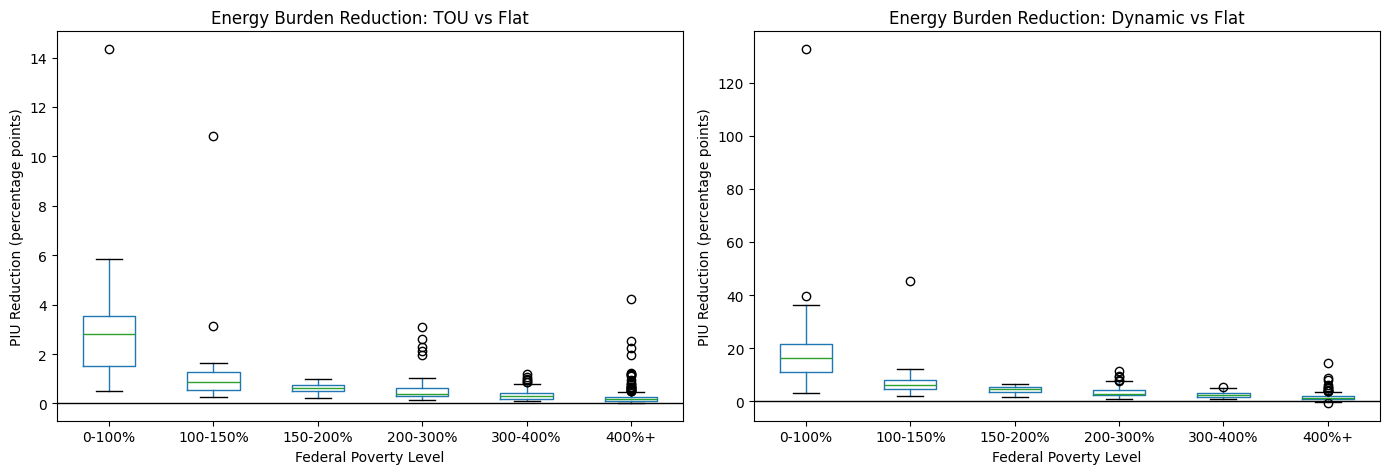


=== Buildings with Lower Energy Burden by Income Level ===

0-100% (32 buildings):
  TOU reduces burden: 32 buildings (100.0%)
  Dynamic reduces burden: 32 buildings (100.0%)

100-150% (23 buildings):
  TOU reduces burden: 23 buildings (100.0%)
  Dynamic reduces burden: 23 buildings (100.0%)

150-200% (17 buildings):
  TOU reduces burden: 17 buildings (100.0%)
  Dynamic reduces burden: 17 buildings (100.0%)

200-300% (52 buildings):
  TOU reduces burden: 52 buildings (100.0%)
  Dynamic reduces burden: 52 buildings (100.0%)

300-400% (53 buildings):
  TOU reduces burden: 53 buildings (100.0%)
  Dynamic reduces burden: 53 buildings (100.0%)

400%+ (268 buildings):
  TOU reduces burden: 268 buildings (100.0%)
  Dynamic reduces burden: 266 buildings (99.3%)


In [60]:
# Compare energy burden reduction across tariffs by income level

if 'df_piu' in locals() and "in.federal_poverty_level" in df_piu.columns:
    # Filter for valid poverty level data
    df_piu_compare = df_piu[
        (df_piu["in.federal_poverty_level"].notna()) &
        (df_piu["in.federal_poverty_level"] != "Not Available")
    ].copy()
    
    if not df_piu_compare.empty:
        # Compute PIU reductions relative to flat tariff
        df_piu_compare["piu_reduction_tou"] = df_piu_compare["piu_flat"] - df_piu_compare["piu_tou"]
        df_piu_compare["piu_reduction_dynamic"] = df_piu_compare["piu_flat"] - df_piu_compare["piu_dynamic"]
        
        # Average PIU reduction by poverty level
        piu_reduction_summary = df_piu_compare.groupby("in.federal_poverty_level")[
            ["piu_reduction_tou", "piu_reduction_dynamic"]
        ].agg(['mean', 'median'])
        
        print("=== Average PIU Reduction by Income Level (percentage points) ===")
        print("Positive values = lower burden under alternative tariff\n")
        display(piu_reduction_summary)
        
        # Visualize PIU reduction by poverty level
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # TOU reduction
        df_piu_compare.boxplot(
            column="piu_reduction_tou",
            by="in.federal_poverty_level",
            ax=axes[0],
            grid=False,
        )
        axes[0].axhline(0, color="k", linestyle="-", linewidth=1)
        axes[0].set_title("Energy Burden Reduction: TOU vs Flat")
        axes[0].set_xlabel("Federal Poverty Level")
        axes[0].set_ylabel("PIU Reduction (percentage points)")
        axes[0].get_figure().suptitle("")
        
        # Dynamic reduction
        df_piu_compare.boxplot(
            column="piu_reduction_dynamic",
            by="in.federal_poverty_level",
            ax=axes[1],
            grid=False,
        )
        axes[1].axhline(0, color="k", linestyle="-", linewidth=1)
        axes[1].set_title("Energy Burden Reduction: Dynamic vs Flat")
        axes[1].set_xlabel("Federal Poverty Level")
        axes[1].set_ylabel("PIU Reduction (percentage points)")
        axes[1].get_figure().suptitle("")
        
        plt.tight_layout()
        plt.show()
        
        # Count buildings that see burden reduction
        print("\n=== Buildings with Lower Energy Burden by Income Level ===")
        for poverty_level in sorted(df_piu_compare["in.federal_poverty_level"].unique()):
            subset = df_piu_compare[df_piu_compare["in.federal_poverty_level"] == poverty_level]
            total = len(subset)
            
            tou_better = (subset["piu_reduction_tou"] > 0).sum()
            tou_pct = (tou_better / total) * 100
            
            dynamic_better = (subset["piu_reduction_dynamic"] > 0).sum()
            dynamic_pct = (dynamic_better / total) * 100
            
            print(f"\n{poverty_level} ({total} buildings):")
            print(f"  TOU reduces burden: {tou_better} buildings ({tou_pct:.1f}%)")
            print(f"  Dynamic reduces burden: {dynamic_better} buildings ({dynamic_pct:.1f}%)")
    else:
        print("No valid poverty level data for comparison")
else:
    print("df_piu not available or missing poverty level data")